In [1]:
import pandas as pd
import numpy as np
import requests
import os
from random import sample
import re
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Gather

Code for downloading Udacity's Dog Prediction Data

In [2]:
#url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
#r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
# make a directory if one does not already exist
#folder_name = 'dog_predictions'
#if not os.path.exists(folder_name):
    #os.makedirs(folder_name)

In [4]:
#with open(os.path.join(folder_name, 
                           #url.split('/')[-1]), mode='wb') as file:
             #file.write(r.content)

Initializing All Relevant Datasets

In [5]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive;

In [6]:
predicts = pd.read_csv('dog_predictions/image-predictions.tsv', sep='\t')
predicts;

In [7]:
twitter_api = pd.read_csv('twitter_api_data.csv')
twitter_api;

# Assess

### Documented Issues

`twitter_archive`
#### Quality
- timestamp is a string and not datetime
- text column irrelevant material
- 137 duplicate posts (possibly because they are reposted) many duplicates have the tag "RT @dog_rates: " before
- texts must be stripped of "RT @dog_rates: "
- There are 42 instances where categorical variables are found in the text, but are not accurately accounted for in the categorical columns
- There are 109 instances where the name column is not accurate, (ex: index 542 name is considered "incredibly" since text before contains "incredible"), and an incorrect name is in place.
    - I recognize that it is an oversight that I cannot test whether or not a name is missed because I do not yet have knowledge of a language processing library.
- Missing rows in "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"
- Ratings may contain floats. Texts needs to be checked again
- change id to string
- drop expanded url and source, as they are incomplete and not useful for analysis

#### Tidiness
- text column contains a source variable for the tweet
- dog "ages/types" (floofer, pupper etc.) should be single, categorial column

`predicts`
#### Quality
- prediction dog breeds have inconsistent casing
- column titles should be be full names
- change id to string
- extract predictions for images where predictions are both dogs and above 70% confidence
    - If our confidence level is too low, then our statements become less meaningful. However, because I am not sure how to test the accuracy of the predictions, I will choose a lowish confidence level since I am aware that many of the pictures will contain dogs.

#### Tidiness
 

`twitter_api`
#### Quality
- change id to string (should have done this when extracting)
- change retweet and favorite to int

#### Tidiness
- tables need to be reorganized
    - 1 for souce metadata (urls

In [8]:
pd.set_option('display.max_colwidth', -1)

### twitter_archive

#### Visual Assessment

In [9]:
#to be used for visual assessments. Supressed to save space.
twitter_archive.sample(5);

In [10]:
twitter_archive.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [11]:
#no duplicated values
list(twitter_archive.text.duplicated()).count(True)

0

In [12]:
#to be used for visual assessments. commented out to save space
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
#investigating max values for numerator/denominator
twitter_archive.describe();

#### Function(s) used for progrmattic assessment

In [14]:
def category_accuracy(df, columns_list):
    '''category_accuracy parses through the texts column of a dataframe and checks if the information matches
    the values of the categorical columns, GIVEN that the text is used as the categorical variable source
    and categorical column values are the same as column header.
    Restrictions: text column must be called "text".
    Returns: category_accuracy returns the index of rows where the categorical values do not match the text'''
    offending_rows = []
    # matching text with other columns
    #itterate through df
    for index, row in df.iterrows():
        match = []
        #current values in columns
        secondary = [row[column] for column in columns_list]
        #going through every word and checking for classification qualification
        source = row.text.split()
        for word in source:
            match += [value for value in columns_list if value in word and pd.notnull(word) and word != 'None']
    #checking for accuracy
        #if there was more than one match, was it accurate?
        if len(match)> 0:
            test = []
            #this loops checks to see if the row value is the same as the matched value
            for current in secondary:
                for i in match:
                    test.append(i == current)
            # if there are less correct than actual matches, then there is an inaccurate column.
            if test.count(True) < len(match):
                offending_rows.append(index)
    return offending_rows

### Parsing Text for Accuracy

In [15]:
#category_accuracy(df, columns)
offending_categorical_rows = category_accuracy(twitter_archive, ['doggo', 'floofer', 'pupper', 'puppo'])
print('The number of instances where doggo, floofer, pupper, and puppo is found in the text, but does not have the correct value is: ', len(offending_categorical_rows))

The number of instances where doggo, floofer, pupper, and puppo is found in the text, but does not have the correct value is:  42


In [16]:
print('The list of offending rows: ', offending_categorical_rows)

The list of offending rows:  [54, 83, 85, 106, 134, 172, 228, 268, 274, 296, 302, 475, 477, 545, 798, 934, 946, 987, 993, 1027, 1093, 1120, 1220, 1228, 1254, 1265, 1351, 1516, 1634, 1635, 1636, 1643, 1710, 1712, 1743, 1826, 1843, 1847, 1862, 1900, 1928, 2141]


In [17]:
#investigate offending rows. Rows had issues. Code has been commented out to save space.
#for i in offending_categorical_rows:
    #display(twitter_archive[twitter_archive.index == i])

### Checking Names Column

Since names are capitalized, names that are lowercase will be flagged as they will likely not be actual names.

In [18]:
#demonstrating regular names
regular_names = []
for name in twitter_archive.name:
    if name[0].isupper() and name != 'None' and pd.notnull(name):
        regular_names.append(name)
sample(regular_names, 20)

['Cash',
 'Reggie',
 'Dutch',
 'Archie',
 'Klevin',
 'Wyatt',
 'Apollo',
 'Frankie',
 'Leonard',
 'Spencer',
 'Winston',
 'Oakley',
 'Jareld',
 'Striker',
 'Zoey',
 'Doobert',
 'Mason',
 'Bentley',
 'Kirk',
 'Kaiya']

In [19]:
#flagging lowercase names and index
incorrect_names = []
for index, row in twitter_archive.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names
#len(incorrect_names) returns 109 instances

[('such', 22),
 ('a', 56),
 ('quite', 118),
 ('quite', 169),
 ('quite', 193),
 ('not', 335),
 ('one', 369),
 ('incredibly', 542),
 ('a', 649),
 ('mad', 682),
 ('an', 759),
 ('very', 773),
 ('a', 801),
 ('very', 819),
 ('just', 822),
 ('my', 852),
 ('one', 924),
 ('not', 988),
 ('his', 992),
 ('one', 993),
 ('a', 1002),
 ('a', 1004),
 ('a', 1017),
 ('an', 1025),
 ('very', 1031),
 ('actually', 1040),
 ('a', 1049),
 ('just', 1063),
 ('getting', 1071),
 ('mad', 1095),
 ('very', 1097),
 ('this', 1120),
 ('unacceptable', 1121),
 ('all', 1138),
 ('a', 1193),
 ('old', 1206),
 ('a', 1207),
 ('infuriating', 1259),
 ('a', 1340),
 ('a', 1351),
 ('a', 1361),
 ('an', 1362),
 ('a', 1368),
 ('a', 1382),
 ('very', 1385),
 ('getting', 1435),
 ('just', 1457),
 ('a', 1499),
 ('the', 1527),
 ('the', 1603),
 ('actually', 1693),
 ('by', 1724),
 ('a', 1737),
 ('officially', 1747),
 ('a', 1785),
 ('the', 1797),
 ('the', 1815),
 ('a', 1853),
 ('a', 1854),
 ('a', 1877),
 ('a', 1878),
 ('life', 1916),
 ('a', 1923

## predicts

In [20]:
predicts.sample(5)

tweet_id                                          jpg_url  \
1958  865359393868664832  https://pbs.twimg.com/media/DAJfxqGVoAAnvQt.jpg   
1738  822244816520155136  https://pbs.twimg.com/media/C2kzTGxWEAEOpPL.jpg   
2041  885311592912609280  https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg   
1305  753375668877008896  https://pbs.twimg.com/media/CnSHLFeWgAAwV-I.jpg   
1854  841077006473256960  https://pbs.twimg.com/media/C6wbE5bXUAAh1Hv.jpg   

      img_num                        p1   p1_conf  p1_dog                  p2  \
1958  2        Chesapeake_Bay_retriever  0.832435  True    Labrador_retriever   
1738  1        Samoyed                   0.585441  True    Pomeranian           
2041  1        Labrador_retriever        0.908703  True    seat_belt            
1305  1        bluetick                  0.360071  True    crutch               
1854  1        Brittany_spaniel          0.962985  True    Blenheim_spaniel     

       p2_conf  p2_dog          p3   p3_conf  p3_dog  
1958  0.163551  True    Weimaraner  0.002770  True    
1738  0.193654  True    Arctic_fox  0.071648  False   
2041  0.057091  False   pug         0.011933  True    
1305  0.134816  False   tripod      0.098207  False   
1854  0.014820  True    clumber     0.009557  True

In [21]:
predicts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## twitter_api

In [22]:
twitter_api.sample(5)

id favorite_count retweet_count  \
2097  670733412878163972  953            507            
2338  666104133288665088  13787          6172           
262   842765311967449089  6887           1313           
785   775085132600442880  16184          4943           
1277  709042156699303936  4857           1673           

                                                         expanded_url  
2097  https://twitter.com/dog_rates/status/670733412878163972/photo/1  
2338  https://twitter.com/dog_rates/status/666104133288665088/photo/1  
262   https://twitter.com/i/web/status/842765311967449089              
785   https://twitter.com/dog_rates/status/775085132600442880/photo/1  
1277  https://twitter.com/dog_rates/status/709042156699303936/photo/1

In [23]:
twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
id                2356 non-null int64
favorite_count    2356 non-null object
retweet_count     2356 non-null object
expanded_url      2299 non-null object
dtypes: int64(1), object(3)
memory usage: 73.7+ KB


# Clean

Creating Cleaning Copies

In [24]:
twitter_archive_clean = twitter_archive.copy()

In [25]:
predicts_clean = predicts.copy()

In [26]:
twitter_api_clean = twitter_api.copy()

### Twitter Archive

#### Quality
- timestamp is a string and not datetime
- text column irrelevant material
- 137 duplicate posts, possible because they are reposted? many duplicates have the tag "RT @dog_rates: " before
- texts must be stripped of "RT @dog_rates: "
- There are 42 instances where categorical variables are found in the text, but are not accurately accounted for in the categorical columns
- There are 109 instances where the name column is not accurate, (ex: index 542 name is considered "incredibly" since text before contains "incredible"), and an incorrect name is in place.
    - I recognize I cannot test whether or not a name is missed because I do not have knowledge of a language processing library. Thus there may be names that are incorrect but undetectable
- Missing rows in "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"
- Ratings may contain floats. Texts needs to be checked again
- change id to string
- drop expanded url and source, as they are incomplete and not useful for analysis
- tweet_id: 881633300179243008 contains two ratings, the latter is the correct one

#### Tidiness
- text column contains a source variable for the tweet
- dog "ages/types" (floofer, pupper etc.) should be single, categorial column

#### Define 
Use astype to change timestamp to timedate

#### Code

In [27]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive.timestamp)

#### Test

In [28]:
#timestamp was successfully changed to datetime, commented for space
#twitter_archive_clean.info()

#### Define
Use str.replace to remove unwanted url from text column

#### Code

In [29]:
#testing
twitter_archive.text[0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [30]:
#regex citation: https://stackoverflow.com/questions/6038061/regular-expression-to-find-urls-within-a-string
#regex expression has been altered to work with the dataset (elipses and other perumutations have been added)
#includes characacters :// 
#([\w_-]+(?:(?:\.[\w_-]+)+))groups combonations of "alphanumeric.alphanumeric"
#([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])? groups combonations of alphanumeric and special symbols
text = re.sub(r'(\\n\\nhttps|http|ftp|https)([:…/]+)([\w_…-]*(?:(?:\.[\w_…-]*)*))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-…]*)?', '', twitter_archive.text[0], flags = re.MULTILINE)
text

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 "

In [31]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(\\n\\nhttps|http|ftp|https)([:…/]+)([\w_…-]*(?:(?:\.[\w_…-]*)*))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-…]*)?', '');

#### Test

In [32]:
[i for i in twitter_archive_clean.text if 'https' in i]

[]

In [33]:
#urls removed, supressed for space
twitter_archive_clean.text;

In [34]:
twitter_archive_clean.sample(5);

#### Define
Remove "RT @dog_rates: " replace

#### Code

In [35]:
twitter_archive_clean.text = twitter_archive_clean.text.str.replace(r'(RT @dog_rates: )', '');

#### Test

In [36]:
for i in twitter_archive_clean.text:
    if 'RT @dog_rates: ' in i:
        print(i)

#### Define
Drop Duplicates tweets. Although they might have different meta data, they are still the same "tweet" and having duplicates will alter the analysis

#### Code

In [37]:
#investigate duplicates?
list(twitter_archive_clean.text.duplicated()).count(True)

137

In [38]:
#dropping all duplicates based on text data
twitter_archive_clean.drop_duplicates('text', keep = 'first', inplace = True)
twitter_archive_clean.reset_index(inplace = True)

#### Test

In [39]:
#former shape was 2356. 2356 - 2219 = 137
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 18 columns):
index                         2219 non-null int64
tweet_id                      2219 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2219 non-null datetime64[ns, UTC]
source                        2219 non-null object
text                          2219 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2160 non-null object
rating_numerator              2219 non-null int64
rating_denominator            2219 non-null int64
name                          2219 non-null object
doggo                         2219 non-null object
floofer                       2219 non-null object
pupper                        2219 non-null object
puppo               

#### Define
Investigate and fix innacurate classification, using modified categorical_accuracy function

#### Code

In [40]:
for i in offending_categorical_rows:
    display(twitter_archive_clean[twitter_archive_clean.index == i])

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
54  55     881633300179243008  8.816070e+17           47384430.0            

                   timestamp  \
54 2017-07-02 21:58:53+00:00   

                                                                                source  \
54  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                           text  \
54  @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s   

    retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
54 NaN                  NaN                        NaN                         

   expanded_urls  rating_numerator  rating_denominator  name doggo floofer  \
54  NaN           17                10                  None  None  None     

   pupper puppo  
54  None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
83  85     876120275196170240 NaN                    NaN                    

                   timestamp  \
83 2017-06-17 16:52:05+00:00   

                                                                                source  \
83  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                             text  \
83  Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite    

    retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
83 NaN                  NaN                        NaN                         

                                                      expanded_urls  \
83  https://twitter.com/dog_rates/status/876120275196170240/photo/1   

    rating_numerator  rating_denominator   name doggo floofer pupper puppo  
83  13                10                  Venti  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
85  87     875144289856114688 NaN                    NaN                    

                   timestamp  \
85 2017-06-15 00:13:52+00:00   

                                                                                source  \
85  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                      text  \
85  Meet Nugget and Hank. Nugget took Hank's bone. Hank is wondering if you would please return it to him. Both 13/10 would not intervene    

    retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
85 NaN                  NaN                        NaN                         

                                                      expanded_urls  \
85  https://twitter.com/dog_rates/status/875144289856114688/video/1   

    rating_numerator  rating_denominator    name doggo floofer pupper puppo  
85  13                10                  Nugget  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
106  108    871515927908634625 NaN                    NaN                    

                    timestamp  \
106 2017-06-04 23:56:03+00:00   

                                                                                 source  \
106  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                              text  \
106  This is Napolean. He's a Raggedy East Nicaraguan Zoom Zoom. Runs on one leg. Built for deception. No eyes. Good with kids. 12/10 great doggo    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
106 NaN                  NaN                        NaN                         

                                                                                                                       expanded_urls  \
106  https://twitter.com/dog_rates/status/871515927908634625/photo/1,https://twitter.com/dog_rates/status/871515927908634625/photo/1   

     rating_numerator  rating_denominator      name  doggo floofer pupper  \
106  12                10                  Napolean  doggo  None    None    

    puppo  
106  None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
134  139    865359393868664832 NaN                    NaN                    

                    timestamp  \
134 2017-05-19 00:12:11+00:00   

                                                                                 source  \
134  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                 text  \
134  This is Sammy. Her tongue ejects without warning sometimes. It's a serious condition. Needs a hefty dose from a BlepiPen. 13/10    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
134 NaN                  NaN                        NaN                         

                                                                                                                       expanded_urls  \
134  https://twitter.com/dog_rates/status/865359393868664832/photo/1,https://twitter.com/dog_rates/status/865359393868664832/photo/1   

     rating_numerator  rating_denominator   name doggo floofer pupper puppo  
134  13                10                  Sammy  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
172  177    857393404942143489 NaN                    NaN                    

                    timestamp  \
172 2017-04-27 00:38:11+00:00   

                                                                                 source  \
172  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                      text  \
172  Instead of the usual nightly dog rate, I'm sharing this story with you. Meeko is 13/10 and would like your help \n\n    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
172 NaN                  NaN                        NaN                         

                                                                                                                                                                                                                                                                                                          expanded_urls  \
172  https://www.gofundme.com/meeko-needs-heart-surgery,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1,https://twitter.com/dog_rates/status/857393404942143489/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
172  13                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
228  233    847842811428974592 NaN                    NaN                    

                    timestamp  \
228 2017-03-31 16:07:33+00:00   

                                                                                 source  \
228  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                       text  \
228  This is Rontu. He is described as a pal, cuddle bug, protector and constant shadow. 12/10, but he needs your help\n\n    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
228 NaN                  NaN                        NaN                         

                                                                                                expanded_urls  \
228  https://www.gofundme.com/help-save-rontu,https://twitter.com/dog_rates/status/847842811428974592/photo/1   

     rating_numerator  rating_denominator   name doggo floofer pupper puppo  
228  12                10                  Rontu  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
268  274    840698636975636481  8.406983e+17           8.405479e+17          

                    timestamp  \
268 2017-03-11 22:59:09+00:00   

                                                                                 source  \
268  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                         text  \
268  @0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin   

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
268 NaN                  NaN                        NaN                         

    expanded_urls  rating_numerator  rating_denominator  name doggo floofer  \
268  NaN           10                10                  None  None  None     

    pupper puppo  
268  None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
274  280    839549326359670784 NaN                    NaN                    

                    timestamp  \
274 2017-03-08 18:52:12+00:00   

                                                                                 source  \
274  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                     text  \
274  Meet Winston. He knows he's a little too big for the swing, but he doesn't care. Kindly requests a push. 12/10 would happily oblige    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
274 NaN                  NaN                        NaN                         

                                                       expanded_urls  \
274  https://twitter.com/dog_rates/status/839549326359670784/photo/1   

     rating_numerator  rating_denominator     name doggo floofer pupper puppo  
274  12                10                  Winston  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
296  303    836397794269200385 NaN                    NaN                    

                    timestamp  \
296 2017-02-28 02:09:08+00:00   

                                                                                 source  \
296  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                      text  \
296  This is Buddy. He ran into a glass door once. Now he's h*ckin skeptical. 13/10 empowering af (vid by Brittany Gaunt)    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
296  8.178278e+17         4.196984e+09              2017-01-07 20:18:46 +0000   

                                                       expanded_urls  \
296  https://twitter.com/dog_rates/status/817827839487737858/video/1   

     rating_numerator  rating_denominator   name doggo floofer pupper puppo  
296  13                10                  Buddy  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
302  309    835536468978302976 NaN                    NaN                    

                    timestamp  \
302 2017-02-25 17:06:32+00:00   

                                                                                 source  \
302  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                       text  \
302  Meet Lola. Her hobbies include being precious af and using her foot as a toothbrush. 12/10 Lola requests your help\n\n   

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
302  8.352641e+17         4.196984e+09              2017-02-24 23:04:14 +0000   

                                                                                                                                                                                expanded_urls  \
302  https://www.gofundme.com/lolas-life-saving-surgery-funds,https://twitter.com/dog_rates/status/835264098648616962/photo/1,https://twitter.com/dog_rates/status/835264098648616962/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
302  12                10                  Lola  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
475  497    813142292504645637 NaN                    NaN                    

                    timestamp  \
475 2016-12-25 22:00:04+00:00   

                                                                                 source  \
475  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                      text  \
475  Everybody stop what you're doing and look at this dog with her tiny Santa hat. 13/10    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
475 NaN                  NaN                        NaN                         

                                                                                                                                                                                       expanded_urls  \
475  https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
475  13                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
477  499    813127251579564032 NaN                    NaN                    

                    timestamp  \
477 2016-12-25 21:00:18+00:00   

                                                                                 source  \
477  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                           text  \
477  Here's an anonymous doggo that appears to be very done with Christmas. 11/10 cheer up pup    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
477 NaN                  NaN                        NaN                         

                                                                                                                       expanded_urls  \
477  https://twitter.com/dog_rates/status/813127251579564032/photo/1,https://twitter.com/dog_rates/status/813127251579564032/photo/1   

     rating_numerator  rating_denominator  name  doggo floofer pupper puppo  
477  11                10                  None  doggo  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
545  572    801285448605831168 NaN                    NaN                    

                    timestamp  \
545 2016-11-23 04:45:12+00:00   

                                                                                 source  \
545  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

               text  retweeted_status_id  retweeted_status_user_id  \
545  oh h*ck 10/10  NaN                  NaN                         

    retweeted_status_timestamp  \
545  NaN                         

                                                       expanded_urls  \
545  https://twitter.com/dog_rates/status/801285448605831168/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
545  10                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
798  869    761745352076779520 NaN                    NaN                    

                    timestamp  \
798 2016-08-06 02:06:59+00:00   

                                                                                 source  \
798  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                      text  \
798  Guys.. we only rate dogs. Pls don't send any more pics of the Loch Ness Monster. Only send in dogs. Thank you. 11/10    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
798 NaN                  NaN                        NaN                         

                                                       expanded_urls  \
798  https://twitter.com/dog_rates/status/761745352076779520/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
798  11                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
934  1016   746906459439529985  7.468859e+17           4.196984e+09          

                    timestamp  \
934 2016-06-26 03:22:31+00:00   

                                                                                 source  \
934  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                 text  \
934  PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
934 NaN                  NaN                        NaN                         

                                                       expanded_urls  \
934  https://twitter.com/dog_rates/status/746906459439529985/photo/1   

     rating_numerator  rating_denominator  name doggo floofer pupper puppo  
934  0                 10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
946  1029   745712589599014916 NaN                    NaN                    

                    timestamp  \
946 2016-06-22 20:18:30+00:00   

                                                                                 source  \
946  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                   text  \
946  This is Percy. He fell asleep at the wheel. Irresponsible af. 7/10 absolute menace on the roadway    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
946 NaN                  NaN                        NaN                         

                                                       expanded_urls  \
946  https://twitter.com/dog_rates/status/745712589599014916/photo/1   

     rating_numerator  rating_denominator   name doggo floofer pupper puppo  
946  7                 10                  Percy  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
987  1075   739623569819336705 NaN                    NaN                    

                    timestamp  \
987 2016-06-06 01:02:55+00:00   

                                                              source  \
987  <a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>   

                                                                                        text  \
987  Here's a doggo that don't need no human. 12/10 independent af (vid by @MichelleLiuCee)    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
987 NaN                  NaN                        NaN                         

                     expanded_urls  rating_numerator  rating_denominator  \
987  https://vine.co/v/iY9Fr1I31U6  12                10                   

     name  doggo floofer pupper puppo  
987  None  doggo  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
993  1083   738537504001953792 NaN                    NaN                    

                    timestamp  \
993 2016-06-03 01:07:16+00:00   

                                                                                 source  \
993  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                    text  \
993  This is Bayley. She fell asleep trying to escape her evil fence enclosure. 11/10 night night puppo    

     retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
993 NaN                  NaN                        NaN                         

                                                                                                                       expanded_urls  \
993  https://twitter.com/dog_rates/status/738537504001953792/photo/1,https://twitter.com/dog_rates/status/738537504001953792/photo/1   

     rating_numerator  rating_denominator    name doggo floofer pupper  puppo  
993  11                10                  Bayley  None  None    None   puppo

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1027  1120   731156023742988288 NaN                    NaN                    

                     timestamp  \
1027 2016-05-13 16:15:54+00:00   

                                                                                  source  \
1027  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                    text  \
1027  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once    

      retweeted_status_id  retweeted_status_user_id  \
1027 NaN                  NaN                         

     retweeted_status_timestamp  \
1027  NaN                         

                                                        expanded_urls  \
1027  https://twitter.com/dog_rates/status/731156023742988288/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1027  204               170                 this  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1093  1188   718454725339934721 NaN                    NaN                    

                     timestamp  \
1093 2016-04-08 15:05:29+00:00   

                                                                                  source  \
1093  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                      text  \
1093  This pic is old but I hadn't seen it until today and had to share. Creative af. 13/10 very good boy, would pet well    

      retweeted_status_id  retweeted_status_user_id  \
1093 NaN                  NaN                         

     retweeted_status_timestamp  \
1093  NaN                         

                                                        expanded_urls  \
1093  https://twitter.com/dog_rates/status/718454725339934721/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1093  13                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1120  1215   715009755312439296 NaN                    NaN                    

                     timestamp  \
1120 2016-03-30 02:56:24+00:00   

                                                                                  source  \
1120  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                            text  \
1120  This is Siba. She's remarkably mobile. Very sleepy as well. 12/10 would happily transport    

      retweeted_status_id  retweeted_status_user_id  \
1120 NaN                  NaN                         

     retweeted_status_timestamp  \
1120  NaN                         

                                                        expanded_urls  \
1120  https://twitter.com/dog_rates/status/715009755312439296/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1120  12                10                  Siba  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1220  1319   706516534877929472 NaN                    NaN                    

                     timestamp  \
1220 2016-03-06 16:27:23+00:00   

                                                                                  source  \
1220  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                         text  \
1220  Please enjoy this pup in a cooler. Permanently ready for someone to throw a tennis ball his way. 12/10    

      retweeted_status_id  retweeted_status_user_id  \
1220 NaN                  NaN                         

     retweeted_status_timestamp  \
1220  NaN                         

                                                        expanded_urls  \
1220  https://twitter.com/dog_rates/status/706516534877929472/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1220  12                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1228  1327   705975130514706432 NaN                    NaN                    

                     timestamp  \
1228 2016-03-05 04:36:02+00:00   

                                                                                  source  \
1228  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                    text  \
1228  This is Adele. Her tongue flies out of her mouth at random. It's a debilitating illness. 10/10 stay strong pupper    

      retweeted_status_id  retweeted_status_user_id  \
1228 NaN                  NaN                         

     retweeted_status_timestamp  \
1228  NaN                         

                                                                                                                        expanded_urls  \
1228  https://twitter.com/dog_rates/status/705975130514706432/photo/1,https://twitter.com/dog_rates/status/705975130514706432/photo/1   

      rating_numerator  rating_denominator   name doggo floofer  pupper puppo  
1228  10                10                  Adele  None  None    pupper  None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1254  1354   703631701117943808 NaN                    NaN                    

                     timestamp  \
1254 2016-02-27 17:24:05+00:00   

                                                                                  source  \
1254  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                  text  \
1254  This is Bella. Based on this picture she's at least 8ft tall (wow)! Must be rare. 11/10 would pet on tippy toes    

      retweeted_status_id  retweeted_status_user_id  \
1254 NaN                  NaN                         

     retweeted_status_timestamp  \
1254  NaN                         

                                                                                                                                                                                                                                                        expanded_urls  \
1254  https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1,https://twitter.com/dog_rates/status/703631701117943808/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
1254  11                10                  Bella  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1265  1366   702671118226825216 NaN                    NaN                    

                     timestamp  \
1265 2016-02-25 01:47:04+00:00   

                                                                                  source  \
1265  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                               text  \
1265  Meet Rambo &amp; Kiwi. Rambo's the pup with the sharp toes &amp; rad mohawk. One stays woke while one sleeps. 10/10 for both    

      retweeted_status_id  retweeted_status_user_id  \
1265 NaN                  NaN                         

     retweeted_status_timestamp  \
1265  NaN                         

                                                        expanded_urls  \
1265  https://twitter.com/dog_rates/status/702671118226825216/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
1265  10                10                  Rambo  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1351  1456   695314793360662529 NaN                    NaN                    

                     timestamp  \
1351 2016-02-04 18:35:39+00:00   

                                                                                  source  \
1351  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                         text  \
1351  This is Colin. He really likes green beans. It's tearing his family apart. 10/10 please pray for Colin    

      retweeted_status_id  retweeted_status_user_id  \
1351 NaN                  NaN                         

     retweeted_status_timestamp  \
1351  NaN                         

                                                                                                                                                                                                                                                        expanded_urls  \
1351  https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1,https://twitter.com/dog_rates/status/695314793360662529/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
1351  10                10                  Colin  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1516  1627   684594889858887680 NaN                    NaN                    

                     timestamp  \
1516 2016-01-06 04:38:35+00:00   

                                                                                  source  \
1516  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                               text  \
1516  "FOR THE LAST TIME I DON'T WANNA PLAY TWISTER ALL THE SPOTS ARE GREY DAMN IT CINDY" ...10/10    

      retweeted_status_id  retweeted_status_user_id  \
1516 NaN                  NaN                         

     retweeted_status_timestamp  \
1516  NaN                         

                                                        expanded_urls  \
1516  https://twitter.com/dog_rates/status/684594889858887680/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1516  10                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1634  1755   678774928607469569 NaN                    NaN                    

                     timestamp  \
1634 2015-12-21 03:12:08+00:00   

                                                                                  source  \
1634  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                         text  \
1634  This is Tug. He's not required to wear the cone he just wants his voice to project more clearly. 11/10    

      retweeted_status_id  retweeted_status_user_id  \
1634 NaN                  NaN                         

     retweeted_status_timestamp  \
1634  NaN                         

                                                        expanded_urls  \
1634  https://twitter.com/dog_rates/status/678774928607469569/photo/1   

      rating_numerator  rating_denominator name doggo floofer pupper puppo  
1634  11                10                  Tug  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1635  1756   678767140346941444 NaN                    NaN                    

                     timestamp  \
1635 2015-12-21 02:41:11+00:00   

                                                                                  source  \
1635  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                               text  retweeted_status_id  \
1635  This is Mia. She makes awful decisions. 8/10  NaN                    

      retweeted_status_user_id retweeted_status_timestamp  \
1635 NaN                        NaN                         

                                                        expanded_urls  \
1635  https://twitter.com/dog_rates/status/678767140346941444/photo/1   

      rating_numerator  rating_denominator name doggo floofer pupper puppo  
1635  8                 10                  Mia  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1636  1757   678764513869611008 NaN                    NaN                    

                     timestamp  \
1636 2015-12-21 02:30:45+00:00   

                                                                                  source  \
1636  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                             text  \
1636  Meet Wilson. He got caught humping the futon. He's like "dude, help me out here" 10/10 I'd help Wilson out    

      retweeted_status_id  retweeted_status_user_id  \
1636 NaN                  NaN                         

     retweeted_status_timestamp  \
1636  NaN                         

                                                        expanded_urls  \
1636  https://twitter.com/dog_rates/status/678764513869611008/photo/1   

      rating_numerator  rating_denominator    name doggo floofer pupper puppo  
1636  10                10                  Wilson  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1643  1764   678424312106393600 NaN                    NaN                    

                     timestamp  \
1643 2015-12-20 03:58:55+00:00   

                                                                                  source  \
1643  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                       text  \
1643  This is Crystal. She's a shitty fireman. No sense of urgency. People could be dying Crystal. 2/10 just irresponsible    

      retweeted_status_id  retweeted_status_user_id  \
1643 NaN                  NaN                         

     retweeted_status_timestamp  \
1643  NaN                         

                                                        expanded_urls  \
1643  https://twitter.com/dog_rates/status/678424312106393600/photo/1   

      rating_numerator  rating_denominator     name doggo floofer pupper puppo  
1643  2                 10                  Crystal  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1710  1832   676191832485810177 NaN                    NaN                    

                     timestamp  \
1710 2015-12-14 00:07:50+00:00   

                                                                                  source  \
1710  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                    text  \
1710  These two pups just met and have instantly bonded. Spectacular scene. Mesmerizing af. 10/10 and 7/10 for blue dog    

      retweeted_status_id  retweeted_status_user_id  \
1710 NaN                  NaN                         

     retweeted_status_timestamp  \
1710  NaN                         

                                                                                                                                                                                        expanded_urls  \
1710  https://twitter.com/dog_rates/status/676191832485810177/photo/1,https://twitter.com/dog_rates/status/676191832485810177/photo/1,https://twitter.com/dog_rates/status/676191832485810177/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1710  10                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1712  1834   676121918416756736 NaN                    NaN                    

                     timestamp  \
1712 2015-12-13 19:30:01+00:00   

                                                               source  \
1712  <a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>   

                                                                                                              text  \
1712  Here we are witnessing a very excited dog. Clearly has no control over neck movements. 8/10 would still pet    

      retweeted_status_id  retweeted_status_user_id  \
1712 NaN                  NaN                         

     retweeted_status_timestamp                  expanded_urls  \
1712  NaN                        https://vine.co/v/iZXg7VpeDAv   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1712  8                 10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1743  1867   675334060156301312 NaN                    NaN                    

                     timestamp  \
1743 2015-12-11 15:19:21+00:00   

                                                                                  source  \
1743  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                            text  retweeted_status_id  \
1743  Good morning here's a grass pupper. 12/10  NaN                    

      retweeted_status_user_id retweeted_status_timestamp  \
1743 NaN                        NaN                         

                                                                                                                        expanded_urls  \
1743  https://twitter.com/dog_rates/status/675334060156301312/photo/1,https://twitter.com/dog_rates/status/675334060156301312/photo/1   

      rating_numerator  rating_denominator  name doggo floofer  pupper puppo  
1743  12                10                  None  None  None    pupper  None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1826  1951   673686845050527744 NaN                    NaN                    

                     timestamp  \
1826 2015-12-07 02:13:55+00:00   

                                                                                  source  \
1826  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                        text  \
1826  This is George. He's upset that the 4th of July isn't everyday. 11/10    

      retweeted_status_id  retweeted_status_user_id  \
1826 NaN                  NaN                         

     retweeted_status_timestamp  \
1826  NaN                         

                                                        expanded_urls  \
1826  https://twitter.com/dog_rates/status/673686845050527744/photo/1   

      rating_numerator  rating_denominator    name doggo floofer pupper puppo  
1826  11                10                  George  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1843  1969   673317986296586240 NaN                    NaN                    

                     timestamp  \
1843 2015-12-06 01:48:12+00:00   

                                                                                  source  \
1843  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                  text  \
1843  Take a moment and appreciate how these two dogs fell asleep. Simply magnificent. 10/10 for both    

      retweeted_status_id  retweeted_status_user_id  \
1843 NaN                  NaN                         

     retweeted_status_timestamp  \
1843  NaN                         

                                                                                                                        expanded_urls  \
1843  https://twitter.com/dog_rates/status/673317986296586240/photo/1,https://twitter.com/dog_rates/status/673317986296586240/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1843  10                10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1847  1974   673148804208660480 NaN                    NaN                    

                     timestamp  \
1847 2015-12-05 14:35:56+00:00   

                                                                                  source  \
1847  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                         text  \
1847  This is Fletcher. He's had a ruff night. No more Fireball for Fletcher. 8/10 it'll be over soon pupper    

      retweeted_status_id  retweeted_status_user_id  \
1847 NaN                  NaN                         

     retweeted_status_timestamp  \
1847  NaN                         

                                                        expanded_urls  \
1847  https://twitter.com/dog_rates/status/673148804208660480/photo/1   

      rating_numerator  rating_denominator      name doggo floofer  pupper  \
1847  8                 10                  Fletcher  None  None    pupper   

     puppo  
1847  None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1862  1989   672828477930868736 NaN                    NaN                    

                     timestamp  \
1862 2015-12-04 17:23:04+00:00   

                                                                                  source  \
1862  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                       text  \
1862  This is Jerry. He's a Timbuk Slytherin. Eats his pizza from the side first. Crushed that cup with his bare paws 9/10    

      retweeted_status_id  retweeted_status_user_id  \
1862 NaN                  NaN                         

     retweeted_status_timestamp  \
1862  NaN                         

                                                        expanded_urls  \
1862  https://twitter.com/dog_rates/status/672828477930868736/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
1862  9                 10                  Jerry  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1900  2028   671866342182637568 NaN                    NaN                    

                     timestamp  \
1900 2015-12-02 01:39:53+00:00   

                                                                                  source  \
1900  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                      text  \
1900  Meet Dylan. He can use a fork but clearly can't put on a sweatshirt correctly. Looks like a disgruntled teen. 10/10    

      retweeted_status_id  retweeted_status_user_id  \
1900 NaN                  NaN                         

     retweeted_status_timestamp  \
1900  NaN                         

                                                        expanded_urls  \
1900  https://twitter.com/dog_rates/status/671866342182637568/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
1900  10                10                  Dylan  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
1928  2056   671357843010908160 NaN                    NaN                    

                     timestamp  \
1928 2015-11-30 15:59:17+00:00   

                                                                                  source  \
1928  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                               text  retweeted_status_id  \
1928  Tfw she says hello from the other side. 9/10  NaN                    

      retweeted_status_user_id retweeted_status_timestamp  \
1928 NaN                        NaN                         

                                                                                                                                                                                                                                                        expanded_urls  \
1928  https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1,https://twitter.com/dog_rates/status/671357843010908160/photo/1   

      rating_numerator  rating_denominator  name doggo floofer pupper puppo  
1928  9                 10                  None  None  None    None   None

index            tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
2141  2274   667455448082227200 NaN                    NaN                    

                     timestamp  \
2141 2015-11-19 21:32:34+00:00   

                                                                  source  \
2141  <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>   

                                                                                                                    text  \
2141  This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s    

      retweeted_status_id  retweeted_status_user_id  \
2141 NaN                  NaN                         

     retweeted_status_timestamp  \
2141  NaN                         

                                                        expanded_urls  \
2141  https://twitter.com/dog_rates/status/667455448082227200/photo/1   

      rating_numerator  rating_denominator   name doggo floofer pupper puppo  
2141  7                 10                  Reese  None  None    None   None

In [41]:
def category_correction(df, columns_list):
    '''progrmatically fills columns based on text source'''
    offending_rows = []
    # itterates through rows of dataframe
    for index, row in df.iterrows():
        #current values in columns
        current = [row[column] for column in columns_list]
        #print(index)
        #splitting text
        source = row.text.split()
        #checking if any words in text qualify for categorical classification
        for word in source:
            for value in columns_list:
                if value in word and pd.notnull(word) and word != 'None':
                    df.loc[index, value]= value
    return df

In [42]:
twitter_archive_clean = category_correction(twitter_archive_clean, ['doggo', 'floofer', 'pupper', 'puppo'])

#### Test

In [43]:
#checking to see if changes in offending rows were made. commented for space
#for i in offending_categorical_rows:
#    display(twitter_archive_clean[twitter_archive_clean.index == i])

In [44]:
print('The number of categorical rows with missing or innacurate categories is: ',len(category_accuracy(twitter_archive_clean, ['doggo', 'floofer', 'pupper', 'puppo'])))

The number of categorical rows with missing or innacurate categories is:  0


#### Define
Record Name list by hand, and then change names progratically

#### Code

In [45]:
twitter_archive.expanded_urls[649]

'https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1,https://twitter.com/dog_rates/status/792913359805018113/photo/1'

In [46]:
# Running this script again since observations have been dropped
incorrect_names = []
for index, row in twitter_archive_clean.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names;

In [47]:
#print incorrect name text for manual checking, commented out for space
#for i, index in incorrect_names:
#    print(index)
#    print(twitter_archive_clean.text[index])
#    print()

In [48]:
name_list = ['roxy', 'Grace', 'puffie', 'Forrest', 'Zoey', 'Quizno', 'Wylie', 'Kip', 'Jacob', 'Rufus', 'Spork', 'Cherokee', 'Hemry', 'Alphred', 'Alfredo', 'Leroi', 'Berta', 'Chuk', 'Alfonso', 'Cheryl', 'Jessiga', 'Klint', 'Kohl', 'Daryl', 'Pepe', 'Octaviath', 'Johm']
#iterrating through all incorrect names (looping though all names and programmatically fixing may end up causing more problems than solving)
for i, index in incorrect_names:
    #set all incorrect names to 'None'
    twitter_archive_clean.at[index, 'name'] = 'None'
    #itterate through text to find a matching name
    for word in twitter_archive_clean.text[index].split():
        for name in name_list:
            #correct from None to name if there is a match
            if name in word:
                twitter_archive_clean.at[index, 'name'] = name

#### Test

In [49]:
# runnin "incorrect_names" script again to test if names were changed
#should only return 'puffie' and 'roxy', as those were the only name that was lowercase
incorrect_names = []
for index, row in twitter_archive_clean.iterrows():
    if row['name'][0].islower() and row['name'] != 'None' and pd.notnull(row['name']):
        incorrect_names.append((row['name'], index))
incorrect_names

[('roxy', 22), ('puffie', 55)]

In [50]:
#capitalize puffie and roxy
twitter_archive_clean.at[incorrect_names[0][1], 'name'] = 'Roxy'
twitter_archive_clean.at[incorrect_names[1][1], 'name'] = 'Puffie'

In [51]:
twitter_archive_clean.name[55], twitter_archive_clean.name[22]

('Puffie', 'Roxy')

#### Define
Drop columns "in_reply_to_status_id" "in_reply_to_user_id" "retweeted_status_id" "retweeted_status_user_id" "retweeted_status_timestamp"

#### Code

In [52]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 18 columns):
index                         2219 non-null int64
tweet_id                      2219 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2219 non-null datetime64[ns, UTC]
source                        2219 non-null object
text                          2219 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2160 non-null object
rating_numerator              2219 non-null int64
rating_denominator            2219 non-null int64
name                          2219 non-null object
doggo                         2219 non-null object
floofer                       2219 non-null object
pupper                        2219 non-null object
puppo               

In [53]:
twitter_archive_clean.drop(columns=["in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id", "retweeted_status_timestamp"], inplace = True)

#### Test

In [54]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index                 2219 non-null int64
tweet_id              2219 non-null int64
timestamp             2219 non-null datetime64[ns, UTC]
source                2219 non-null object
text                  2219 non-null object
expanded_urls         2160 non-null object
rating_numerator      2219 non-null int64
rating_denominator    2219 non-null int64
name                  2219 non-null object
doggo                 2219 non-null object
floofer               2219 non-null object
pupper                2219 non-null object
puppo                 2219 non-null object
dtypes: datetime64[ns, UTC](1), int64(4), object(8)
memory usage: 225.4+ KB


#### Define
Change id to string using astype

#### Code

In [55]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str);

#### Test

In [56]:
twitter_archive_clean.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index                 2219 non-null int64
tweet_id              2219 non-null object
timestamp             2219 non-null datetime64[ns, UTC]
source                2219 non-null object
text                  2219 non-null object
expanded_urls         2160 non-null object
rating_numerator      2219 non-null int64
rating_denominator    2219 non-null int64
name                  2219 non-null object
doggo                 2219 non-null object
floofer               2219 non-null object
pupper                2219 non-null object
puppo                 2219 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(9)
memory usage: 225.4+ KB


#### Define
Use str.extract on text to obtain new columns of numerator and denominator
Change new columns to float type using astype

#### Code

In [57]:
twitter_archive_clean['rating'] = twitter_archive_clean.text.str.extract(r'(\d+\.*\d*/\d+\.*\d*)')

In [58]:
twitter_archive_clean['rating'] = twitter_archive_clean['rating'].str.split('/')

In [59]:
twitter_archive_clean[['numerator','denominator']] = pd.DataFrame(twitter_archive_clean.rating.values.tolist(), index= twitter_archive_clean.index)

In [60]:
twitter_archive_clean = twitter_archive_clean.astype({"numerator":'float', "denominator":'float'})

In [61]:
twitter_archive_clean.drop(columns=['rating_numerator', 'rating_denominator', 'rating'], inplace = True)

#### Test

In [62]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 13 columns):
index            2219 non-null int64
tweet_id         2219 non-null object
timestamp        2219 non-null datetime64[ns, UTC]
source           2219 non-null object
text             2219 non-null object
expanded_urls    2160 non-null object
name             2219 non-null object
doggo            2219 non-null object
floofer          2219 non-null object
pupper           2219 non-null object
puppo            2219 non-null object
numerator        2219 non-null float64
denominator      2219 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(9)
memory usage: 225.4+ KB


In [63]:
twitter_archive_clean[twitter_archive_clean['numerator'] == 11.26]

index            tweet_id                 timestamp  \
1596  1712   680494726643068929 2015-12-25 21:06:00+00:00   

                                                                                  source  \
1596  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                     text  \
1596  Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10    

                                                        expanded_urls  name  \
1596  https://twitter.com/dog_rates/status/680494726643068929/photo/1  None   

     doggo floofer  pupper puppo  numerator  denominator  
1596  None  None    pupper  None  11.26      10.0

#### Define
Drop Source and expanded url

#### Code

In [64]:
twitter_archive_clean.drop(columns=['source', 'expanded_urls'], inplace = True)

#### Test

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219 entries, 0 to 2218
Data columns (total 11 columns):
index          2219 non-null int64
tweet_id       2219 non-null object
timestamp      2219 non-null datetime64[ns, UTC]
text           2219 non-null object
name           2219 non-null object
doggo          2219 non-null object
floofer        2219 non-null object
pupper         2219 non-null object
puppo          2219 non-null object
numerator      2219 non-null float64
denominator    2219 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(7)
memory usage: 190.8+ KB


#### Define
Manually change 881633300179243008's incorrect rating

#### Code

In [66]:
display(twitter_archive_clean[twitter_archive_clean.tweet_id == '881633300179243008'])

index            tweet_id                 timestamp  \
54  55     881633300179243008 2017-07-02 21:58:53+00:00   

                                                                                           text  \
54  @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s   

    name doggo floofer pupper puppo  numerator  denominator  
54  None  None  None    None   None  17.0       10.0

In [67]:
twitter_archive_clean.at[54, 'numerator'] = 13.0
twitter_archive_clean.at[54, 'denominator'] = 10.0

#### Test

In [68]:
display(twitter_archive_clean[twitter_archive_clean.tweet_id == '881633300179243008'])

index            tweet_id                 timestamp  \
54  55     881633300179243008 2017-07-02 21:58:53+00:00   

                                                                                           text  \
54  @roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s   

    name doggo floofer pupper puppo  numerator  denominator  
54  None  None  None    None   None  13.0       10.0

#### Define
Use melt to change categories into one column

#### Code

In [69]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars = ['index', 'tweet_id', 'timestamp', 'text', 'name', 'numerator', 'denominator'], value_name = 'dog_stage')

In [70]:
twitter_archive_clean.drop(columns = 'variable', inplace = True)

In [71]:
#drop variable column and drop all duplicates
#twitter_archive_clean.drop(columns = ['variable'], inplace = True)
print('The number of duplicated rows is:', list(twitter_archive_clean.duplicated()).count(True))
twitter_archive_clean.drop_duplicates(inplace = True)

The number of duplicated rows is: 6252


In [72]:
twitter_archive_clean = twitter_archive_clean.reset_index(drop = True)

#### Test

In [73]:
twitter_archive_clean.drop(columns = 'index', inplace = True)

In [74]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
tweet_id       2624 non-null object
timestamp      2624 non-null datetime64[ns, UTC]
text           2624 non-null object
name           2624 non-null object
numerator      2624 non-null float64
denominator    2624 non-null float64
dog_stage      2624 non-null object
dtypes: datetime64[ns, UTC](1), float64(2), object(4)
memory usage: 143.6+ KB


#### Define
Creating rating ratio columns (though it will probably useless for outliers or joke ratings)

#### Code

In [75]:
twitter_archive_clean['rating_ratio'] = twitter_archive_clean.numerator / twitter_archive_clean.denominator

#### Test

In [76]:
twitter_archive_clean.head()

tweet_id                 timestamp  \
0  892420643555336193 2017-08-01 16:23:56+00:00   
1  892177421306343426 2017-08-01 00:17:27+00:00   
2  891815181378084864 2017-07-31 00:18:03+00:00   
3  891689557279858688 2017-07-30 15:58:51+00:00   
4  891327558926688256 2017-07-29 16:00:24+00:00   

                                                                                                                                          text  \
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10                                                         
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10    
2  This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10                     
3  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us                                                               
4  This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek    

       name  numerator  denominator dog_stage  rating_ratio  
0  Phineas   13.0       10.0         None      1.3           
1  Tilly     13.0       10.0         None      1.3           
2  Archie    12.0       10.0         None      1.2           
3  Darla     13.0       10.0         None      1.3           
4  Franklin  12.0       10.0         None      1.2

## Predicts
#### Quality
- prediction dog breeds have inconsistent casing
- column titles should be be full names
- change id to string
- extract predictions for images where predictions are both dogs and above 70% confidence to find 'breed'
    - If our confidence level is too low, then our statements become less meaningful. However, because I am not sure how to test the accuracy of the predictions, I will choose a lowish confidence level since I am aware that many of the pictures will contain dogs.
- predictions should be lower case
- predictions should replace underscore with whitespace

### Tidiness


#### Define
Rename all columns to full names using pd.rename

#### Code

In [77]:
predicts_clean.rename(columns = {'img_num':'image_number', 'p1':'prediction1', 'p1_conf':'prediction1_confidence', 'p1_dog':'prediction1_dog', 'p2':'prediction2', 'p2_conf':'prediction2_confidence', 'p2_dog':'prediction2_dog', 'p3':'prediction3', 'p3_conf':'prediction3_confidence', 'p3_dog':'prediction3_dog'}, inplace = True)

#### Test

In [78]:
list(predicts_clean)

['tweet_id',
 'jpg_url',
 'image_number',
 'prediction1',
 'prediction1_confidence',
 'prediction1_dog',
 'prediction2',
 'prediction2_confidence',
 'prediction2_dog',
 'prediction3',
 'prediction3_confidence',
 'prediction3_dog']

#### Define
use as type to change tweet_id to string

#### Code

In [79]:
predicts_clean.tweet_id = predicts_clean.tweet_id.astype(str)

#### Test

In [80]:
predicts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null object
jpg_url                   2075 non-null object
image_number              2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Define
use str.replace and str.lower to standardize all predictions

#### Code

In [81]:
predicts_clean.prediction1 = predicts_clean.prediction1.str.replace('_', ' ').str.lower()
predicts_clean.prediction2 = predicts_clean.prediction2.str.replace('_', ' ').str.lower()
predicts_clean.prediction3 = predicts_clean.prediction3.str.replace('_', ' ').str.lower();

#### Test

In [82]:
predicts_clean

tweet_id  \
0     666020888022790149   
1     666029285002620928   
2     666033412701032449   
3     666044226329800704   
4     666049248165822465   
5     666050758794694657   
6     666051853826850816   
7     666055525042405380   
8     666057090499244032   
9     666058600524156928   
10    666063827256086533   
11    666071193221509120   
12    666073100786774016   
13    666082916733198337   
14    666094000022159362   
15    666099513787052032   
16    666102155909144576   
17    666104133288665088   
18    666268910803644416   
19    666273097616637952   
20    666287406224695296   
21    666293911632134144   
22    666337882303524864   
23    666345417576210432   
24    666353288456101888   
25    666362758909284353   
26    666373753744588802   
27    666396247373291520   
28    666407126856765440   
29    666411507551481857   
...                  ...   
2045  886366144734445568   
2046  886680336477933568   
2047  886736880519319552   
2048  886983233522544640   
2049  887101392804085760   
2050  887343217045368832   
2051  887473957103951883   
2052  887517139158093824   
2053  887705289381826560   
2054  888078434458587136   
2055  888202515573088257   
2056  888554962724278272   
2057  888804989199671297   
2058  888917238123831296   
2059  889278841981685760   
2060  889531135344209921   
2061  889638837579907072   
2062  889665388333682689   
2063  889880896479866881   
2064  890006608113172480   
2065  890240255349198849   
2066  890609185150312448   
2067  890729181411237888   
2068  890971913173991426   
2069  891087950875897856   
2070  891327558926688256   
2071  891689557279858688   
2072  891815181378084864   
2073  892177421306343426   
2074  892420643555336193   

                                                                                      jpg_url  \
0     https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg                                           
1     https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg                                           
2     https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg                                           
3     https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg                                           
4     https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg                                           
5     https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg                                           
6     https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg                                           
7     https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg                                           
8     https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg                                           
9     https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg                                           
10    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg                                           
11    https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg                                           
12    https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg                                           
13    https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg                                           
14    https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg                                           
15    https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg                                           
16    https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg                                           
17    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg                                           
18    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg                                           
19    https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg                                           
20    https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg                                           
21    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg                                           
22    https://pbs.twimg.com/media/CT9OwFIWEAMuRj

#### Define
create a new columns called dog_breed50, dog_breed60, dog_breed70 etc. with the final numbers representing the minimum level of confidence, given that the picture is actually a dog. 

#### Code

In [83]:
#predicts 1 2 and 3 are in descending order of confidence
print(predicts_clean.shape, list(predicts_clean.prediction1_confidence > predicts_clean.prediction2_confidence).count(True),
list(predicts_clean.prediction2_confidence > predicts_clean.prediction3_confidence).count(True))

(2075, 12) 2075 2075


In [84]:
for index, row in predicts_clean.iterrows():
    predicts_clean.loc[index, 'dog_breed50'] = 'None'
    predicts_clean.loc[index, 'dog_breed60'] = 'None'
    predicts_clean.loc[index, 'dog_breed70'] = 'None'
    predicts_clean.loc[index, 'dog_breed80'] = 'None'
    predicts_clean.loc[index, 'dog_breed90'] = 'None'
#check if picture is a dog and if confidence is high enough
    if row.prediction1_dog == True and row.prediction1_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction1
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction1
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction1
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction1
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction1
#in the case that prediction1 is not a dog, but prediction 2 is (and the confidence is still high), this is probably rare        
    elif row.prediction2_dog == True and row.prediction2_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction2
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction2
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction2
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction2
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction2
#same as above, but an even rarer case for prediction3      
    elif row.prediction3_dog == True and row.prediction3_confidence >= .50:
        predicts_clean.loc[index, 'dog_breed50'] = row.prediction3
        if row.prediction1_confidence >= .60:
            predicts_clean.loc[index, 'dog_breed60'] = row.prediction3
            if row.prediction1_confidence >= .70:
                predicts_clean.loc[index, 'dog_breed70'] = row.prediction3
                if row.prediction1_confidence >= .80:
                    predicts_clean.loc[index, 'dog_breed80'] = row.prediction3
                    if row.prediction1_confidence >= .90:
                        predicts_clean.loc[index, 'dog_breed90'] = row.prediction3

#### Test

In [85]:
predicts_clean;

# Twitter API
`twitter_api`
#### Quality
- change id to string (should have done this when extracting)
- drop expanded_urls
#### Tidiness
- tables need to be reorganized
    - 1 for souce metadata (urls

#### Define
change id to strings

#### Code

In [86]:
twitter_api_clean.id = twitter_api_clean.id.astype(str)

#### Test

In [87]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
id                2356 non-null object
favorite_count    2356 non-null object
retweet_count     2356 non-null object
expanded_url      2299 non-null object
dtypes: object(4)
memory usage: 73.7+ KB


#### Define
drop expanded urls (not neccessary for analysis)

#### Code

In [88]:
twitter_api_clean.drop(columns = 'expanded_url', inplace = True)

#### Test

In [89]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
id                2356 non-null object
favorite_count    2356 non-null object
retweet_count     2356 non-null object
dtypes: object(3)
memory usage: 55.3+ KB


#### Define
rename id to tweet_id

#### Code

In [90]:
twitter_api_clean.rename(columns = {'id': 'tweet_id'}, inplace = True)

#### Test

In [91]:
list(twitter_api_clean)

['tweet_id', 'favorite_count', 'retweet_count']

#### Define
Use astype to change favorite and retweet to int

#### Code

In [92]:
twitter_api_clean['favorite_count'] = pd.to_numeric(twitter_api_clean['favorite_count'], errors='coerce')
twitter_api_clean['retweet_count'] = pd.to_numeric(twitter_api_clean['retweet_count'], errors='coerce')

#### Test

In [93]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
favorite_count    2333 non-null float64
retweet_count     2333 non-null float64
dtypes: float64(2), object(1)
memory usage: 55.3+ KB


# Merge and Store
Final dataframe will contain tweet_id, timestamp, text, name, numerator, denominator, dog_stage, rating_ratio, dog_breed 50-90, retweet, and favorite

In [94]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 8 columns):
tweet_id        2624 non-null object
timestamp       2624 non-null datetime64[ns, UTC]
text            2624 non-null object
name            2624 non-null object
numerator       2624 non-null float64
denominator     2624 non-null float64
dog_stage       2624 non-null object
rating_ratio    2624 non-null float64
dtypes: datetime64[ns, UTC](1), float64(3), object(4)
memory usage: 164.1+ KB


In [95]:
predicts_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 17 columns):
tweet_id                  2075 non-null object
jpg_url                   2075 non-null object
image_number              2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction3               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dog_breed50               2075 non-null object
dog_breed60               2075 non-null object
dog_breed70               2075 non-null object
dog_breed80               2075 non-null object
dog_breed90               2075 non-null object
dtypes: bool(3), float64(3), int64(1), object(10)
memory usage: 233.1+ KB


In [96]:
twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 3 columns):
tweet_id          2356 non-null object
favorite_count    2333 non-null float64
retweet_count     2333 non-null float64
dtypes: float64(2), object(1)
memory usage: 55.3+ KB


In [97]:
twitter_archive_master = twitter_archive_clean.copy()

In [98]:
twitter_archive_master = pd.merge(twitter_archive_master, predicts_clean, how = 'left', on = 'tweet_id')

In [99]:
#drop all unwanted columns
#print(list(twitter_archive_master))
twitter_archive_master.drop(columns = ['jpg_url', 'image_number',
 'prediction1',
 'prediction1_confidence',
 'prediction1_dog',
 'prediction2',
 'prediction2_confidence',
 'prediction2_dog',
 'prediction3',
 'prediction3_confidence',
 'prediction3_dog'], inplace = True)

In [100]:
twitter_archive_master = pd.merge(twitter_archive_master, twitter_api_clean, how = 'left', on = 'tweet_id')

In [101]:
#cleaned dataset v.1!
twitter_archive_master

tweet_id                 timestamp  \
0     892420643555336193 2017-08-01 16:23:56+00:00   
1     892177421306343426 2017-08-01 00:17:27+00:00   
2     891815181378084864 2017-07-31 00:18:03+00:00   
3     891689557279858688 2017-07-30 15:58:51+00:00   
4     891327558926688256 2017-07-29 16:00:24+00:00   
5     891087950875897856 2017-07-29 00:08:17+00:00   
6     890971913173991426 2017-07-28 16:27:12+00:00   
7     890729181411237888 2017-07-28 00:22:40+00:00   
8     890609185150312448 2017-07-27 16:25:51+00:00   
9     890240255349198849 2017-07-26 15:59:51+00:00   
10    890006608113172480 2017-07-26 00:31:25+00:00   
11    889880896479866881 2017-07-25 16:11:53+00:00   
12    889665388333682689 2017-07-25 01:55:32+00:00   
13    889638837579907072 2017-07-25 00:10:02+00:00   
14    889531135344209921 2017-07-24 17:02:04+00:00   
15    889278841981685760 2017-07-24 00:19:32+00:00   
16    888917238123831296 2017-07-23 00:22:39+00:00   
17    888804989199671297 2017-07-22 16:56:37+00:00   
18    888554962724278272 2017-07-22 00:23:06+00:00   
19    888202515573088257 2017-07-21 01:02:36+00:00   
20    888078434458587136 2017-07-20 16:49:33+00:00   
21    887705289381826560 2017-07-19 16:06:48+00:00   
22    887517139158093824 2017-07-19 03:39:09+00:00   
23    887343217045368832 2017-07-18 16:08:03+00:00   
24    887101392804085760 2017-07-18 00:07:08+00:00   
25    886983233522544640 2017-07-17 16:17:36+00:00   
26    886736880519319552 2017-07-16 23:58:41+00:00   
27    886680336477933568 2017-07-16 20:14:00+00:00   
28    886366144734445568 2017-07-15 23:25:31+00:00   
29    886267009285017600 2017-07-15 16:51:35+00:00   
...                  ...                       ...   
2594  871879754684805121 2017-06-06 00:01:46+00:00   
2595  867421006826221569 2017-05-24 16:44:18+00:00   
2596  866686824827068416 2017-05-22 16:06:55+00:00   
2597  859607811541651456 2017-05-03 03:17:27+00:00   
2598  858843525470990336 2017-05-01 00:40:27+00:00   
2599  855851453814013952 2017-04-22 18:31:02+00:00   
2600  848213670039564288 2017-04-01 16:41:12+00:00   
2601  840698636975636481 2017-03-11 22:59:09+00:00   
2602  837366284874571778 2017-03-02 18:17:34+00:00   
2603  825535076884762624 2017-01-29 02:44:34+00:00   
2604  825120256414846976 2017-01-27 23:16:13+00:00   
2605  825026590719483904 2017-01-27 17:04:02+00:00   
2606  822872901745569793 2017-01-21 18:26:02+00:00   
2607  820013781606658049 2017-01-13 21:04:55+00:00   
2608  819952236453363712 2017-01-13 17:00:21+00:00   
2609  816829038950027264 2017-01-05 02:09:53+00:00   
2610  805826884734976000 2016-12-05 17:31:15+00:00   
2611  805823200554876929 2016-12-05 17:16:37+00:00   
2612  803773340896923648 2016-11-30 01:31:12+00:00   
2613  802239329049477120 2016-11-25 19:55:35+00:00   
2614  796563435802726400 2016-11-10 04:01:37+00:00   
2615  793195938047070209 2016-10-31 21:00:23+00:00   
2616  787717603741622272 2016-10-16 18:11:26+00:00   
2617  786051337297522688 2016-10-12 03:50:17+00:00   
2618  756275833623502848 2016-07-21 23:53:04+00:00   
2619  752519690950500352 2016-07-11 15:07:30+00:00   
2620  751132876104687617 2016-07-07 19:16:47+00:00   
2621  744995568523612160 2016-06-20 20:49:19+00:00   
2622  743253157753532416 2016-06-16 01:25:36+00:00   
2623  738537504001953792 2016-06-03 01:07:16+00:00   

                                                                                                                                             text  \
0     This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10                                                         
1     This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10    
2     This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10                     
3     This is Darla. She commenced a snooze mid meal. 13/10 happens to 

# Analysis

### Motivating Questions:
- Which dog stage is most popular? Measured by number of retweets and favorites?
- Which breeds have the highest number of retweets/favorites?
- Do some days attract more viewers than others? This may skew the popularity of a post strictly because of time.

Further questions not explored, but recognized as possible: 
- Given that time of posting is signficant, what sort of breed sould be considered most popular holding time constant?
- Does the gender of a dog influence popularity?
- Does the name of the dog affect retweets/favorites?
- Do higher ratings correlate with more retweets and favorites? Do unique ratings correlate with more retweets and ratings?

## Dog Stage

In [102]:
#Getting mean favorite_count and retweet_count on masked dog_stage
stage_fav = []
for i in ['doggo', 'floofer', 'pupper', 'puppo']:
    fav = twitter_archive_master[twitter_archive_master['dog_stage'] == i].favorite_count.mean()
    stage_fav.append((i, fav))

stage_retweet = []
for j in ['doggo', 'floofer', 'pupper', 'puppo']:
    retweet = twitter_archive_master[twitter_archive_master['dog_stage'] == j].retweet_count.mean()
    stage_retweet.append((j, retweet))

In [103]:
# Geeksforgeeks.com code
# Python code to sort the tuples using second element  
# of sublist Inplace way to sort using sort() 
def Sort(sub_li): 
  
    # reverse = True (Sorts in Descending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    sub_li.sort(key = lambda x: x[1], reverse = True) 
    return sub_li 
print('Average favorites by dog stage in ascending order: ', Sort(stage_fav))
print('Average retweets by dog stage in ascending order: ', Sort(stage_retweet))

Average favorites by dog stage in ascending order:  [('puppo', 17299.823529411766), ('doggo', 12129.494736842105), ('floofer', 10953.8), ('pupper', 4984.996183206107)]
Average retweets by dog stage in ascending order:  [('puppo', 5456.382352941177), ('doggo', 4887.831578947368), ('floofer', 3700.1), ('pupper', 2073.812977099237)]


From this display, it would seem that puppo and doggo are the most popular types of dog stages. However, this sort of analysis does not take into account word popularity. For instance, the the authors of WeRateDogs might simply prefer the terms 'puppo' and 'doggo' more, and may make more posts of them more often. Thus, if the terms puppo and doggo were used more frequently overall, there would be a greater chance of a potentially viral tweet falling under such terms. It could be that the usage of the terms may have an impact on virality, a unique consideration which could possibly be explored using weights based on overall population word-usage, however it seems more probable that content was a greater factor. 

In [104]:
twitter_archive_master.groupby(['dog_stage']).count()['tweet_id']

dog_stage
None       2219
doggo      97  
floofer    10  
pupper     263 
puppo      35  
Name: tweet_id, dtype: int64

At a glance, it is quite interesting to find that puppo is in fact one of the least recorded tweets in the avaliable sample. This fact can help explain the exceptional popularity held by "puppo" stage dogs; with fewer oberservations there are fewer observations to bring down the average.

### Popularity by Weights

In [105]:
weights = list(twitter_archive_master.groupby(['dog_stage']).count()['tweet_id'] / sum([97, 10, 263, 35]))[1:]
weights

[0.23950617283950618,
 0.024691358024691357,
 0.6493827160493827,
 0.08641975308641975]

In [106]:
weight_fav = []
for i in ['doggo', 'floofer', 'pupper', 'puppo']:
    fav = twitter_archive_master[twitter_archive_master['dog_stage'] == i].favorite_count.mean()
    weight_fav.append((i, fav))

weight_retweet = []
for j in ['doggo', 'floofer', 'pupper', 'puppo']:
    retweet = twitter_archive_master[twitter_archive_master['dog_stage'] == j].retweet_count.mean()
    weight_retweet.append((j, retweet))

In [107]:
weight_fav

[('doggo', 12129.494736842105),
 ('floofer', 10953.8),
 ('pupper', 4984.996183206107),
 ('puppo', 17299.823529411766)]

In [108]:
weight_fav[0][1]

12129.494736842105

In [109]:
print('Weighted favorites by dog stage in ascending order: ', Sort([(weight_fav[i][0], weights[i] * weight_fav[i][1]) for i in range(len(weights))]))
print('Weighted retweets by dog stage in ascending order: ', Sort([(weight_retweet[i][0], weights[i] * weight_retweet[i][1]) for i in range(len(weights))]))

Weighted favorites by dog stage in ascending order:  [('pupper', 3237.170360946188), ('doggo', 2905.0888628979856), ('puppo', 1495.0464778503995), ('floofer', 270.46419753086417)]
Weighted retweets by dog stage in ascending order:  [('pupper', 1346.6983036471586), ('doggo', 1170.6658349577647), ('puppo', 471.5392156862745), ('floofer', 91.36049382716048)]


Given weights, the conclusion from before is drastically different. Although this sort of weighting makes it difficult to make out a complete, literal magnitute of popularity, the ordinality of the dog stages is still noteable. For one, puppo, which intially seemed to be a great deal more popular than its other dog stages, had its popularity diminished quite a bit once the overall number of tweets was taken into account. Thus, after weighting it would seem that a pupper is the most popular dog stage. 

Nonetheless, this analysis is still wrought with flaws. As the true age or size of the dog is not recorded, it is difficult to say if these colloquial terms are able accurate representations of a dogs "stage"; especially given that "floofer" seems to be more of a unique type rather than a sequential point in a dogs "staging" (a nuance that likely explains its small representation).

One interesting idea, that is only conjecture and cannot be proven due to lack of data, is that the dog stage terms could be unwitting abstractions of more familiar tropes. For instance, the definition of pupper (Dogtionary), suggests that pupper is by no means limited to age, but generically includes smaller dogs, in addition to having vulnerable or infantile traits. These traits, small or vulenerability, can possibly summed as the term "cute" or by the formal term kindchenschema. Similar translations may possibly exist for the other dog stages. If this is the case, it can be that "cute" content is the most popular kind of content, at least within the demographic in WeRateDogs. However, as stated before, this kind of thinking is baseless and would be much more helpful given proper categorical tags or even some form of machine learning that could determine the content type of the tweet

## Breed


In [110]:
#Create dataframe that stores the confidence based breed, and the summed amount of retweets
breed_retweet_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_retweet = []
    for breed in breed_list:
        breed_retweet_count = twitter_archive_master[twitter_archive_master[i] == breed]['retweet_count'].sum()
        breed_retweet.append((breed, breed_retweet_count))
    breed_conf = pd.DataFrame(Sort(breed_retweet), columns = [i, 'retweet_count'])
    breed_retweet_df = pd.concat([breed_retweet_df, breed_conf], axis = 1)

In [111]:
#Create dataframe that stores the confidence based breed, and the summed amount of favorites
breed_favor_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_favor = []
    for breed in breed_list:
        breed_favor_count = twitter_archive_master[twitter_archive_master[i] == breed]['favorite_count'].sum()
        breed_favor.append((breed, breed_favor_count))
    breed_conf = pd.DataFrame(Sort(breed_favor), columns = [i, 'favorite_count'])
    breed_favor_df = pd.concat([breed_favor_df, breed_conf], axis = 1)

In [112]:
#entire ranking, suppressed for space
breed_favor_df;

In [113]:
#entire retweet ranking based on confidence-dependent breed, supressed for space
breed_retweet_df;

In [114]:
#top 5 most favorited confidence-dependent breeds
breed_favor_df.head(10)

dog_breed50  favorite_count         dog_breed60  favorite_count  \
0  golden retriever    1251276.0       golden retriever    1139314.0        
1  labrador retriever  927273.0        labrador retriever  872655.0         
2  pembroke            910321.0        pembroke            759016.0         
3  chow                304842.0        samoyed             282443.0         
4  samoyed             297134.0        chow                273833.0         
5  chihuahua           294532.0        chihuahua           257028.0         
6  german shepherd     265349.0        french bulldog      239786.0         
7  pomeranian          249205.0        german shepherd     198965.0         
8  french bulldog      239786.0        pug                 180523.0         
9  pug                 212979.0        pomeranian          178472.0         

          dog_breed70  favorite_count               dog_breed80  \
0  golden retriever    907798.0        golden retriever           
1  labrador retriever  818978.0        labrador retriever         
2  pembroke            628987.0        pembroke                   
3  samoyed             280901.0        samoyed                    
4  chihuahua           249772.0        chow                       
5  french bulldog      226176.0        french bulldog             
6  chow                200366.0        pomeranian                 
7  german shepherd     185520.0        pug                        
8  pug                 174660.0        chesapeake bay retriever   
9  pomeranian          173483.0        great pyrenees             

   favorite_count         dog_breed90  favorite_count  
0  685486.0        pembroke            452504.0        
1  645543.0        golden retriever    373902.0        
2  552828.0        samoyed             241303.0        
3  243950.0        french bulldog      149998.0        
4  188211.0        pug                 143678.0        
5  174967.0        labrador retriever  141601.0        
6  170542.0        pomeranian          117234.0        
7  168295.0        shetland sheepdog   91797.0         
8  137755.0        chihuahua           90033.0         
9  134908.0        chow                88057.0

In [115]:
#top 5 most retweeted breeds
breed_retweet_df.head()

dog_breed50  retweet_count         dog_breed60  retweet_count  \
0  golden retriever    439209.0       golden retriever    405867.0        
1  labrador retriever  367831.0       labrador retriever  354965.0        
2  pembroke            252458.0       pembroke            217985.0        
3  samoyed             120876.0       samoyed             102802.0        
4  chihuahua           87301.0        chihuahua           75332.0         

          dog_breed70  retweet_count         dog_breed80  retweet_count  \
0  labrador retriever  336812.0       labrador retriever  288217.0        
1  golden retriever    318406.0       golden retriever    256192.0        
2  pembroke            182637.0       pembroke            158890.0        
3  samoyed             102335.0       samoyed             94518.0         
4  chihuahua           67609.0        pomeranian          63789.0         

          dog_breed90  retweet_count  
0  golden retriever    163570.0       
1  pembroke            127309.0       
2  samoyed             93828.0        
3  labrador retriever  75628.0        
4  pomeranian          48333.0

This analysis takes into consideration varying accuracy of the neural network that predicted the dogs and presents categories of the minimum prediction confidence required to call determine the breed. As a given, higher confidence ensures a greater likelihood that the analyzed image is actually the breed, at the cost of sample size. This most certainly has effects in the ranking of tables, as lower accuracy may have attributed retweets/favorites to a certain breed, when the dog is not that breed at all. For instance, the golden retriever is considered the "most favorited" dog at all levels except the strictest tier of confidence where the pembroke breed pushes it to second. This can suggest that the neural network may tend to favor a golden retiever designation (for undiscernable reasons), or that there are simply a great number of golden retrievers, a point to be reiterated in the following paragraph.

In this display, just as the previous one, it might be deceptive to simply say that golden retrievers/labrador retrievers are the most popular dogs (specifically in terms of viral fame) even if they may seem to dominate the current charts. Rather than considering that such breeds are the "face of the internet", one might consider that Labrador Retrievers and Golden Retrievers are amongst the most popular dogs to own, ranking 1st and 3rd in 2018 according to the American Kennel Club. As some of the most popular dog breeds to own, there will likely be a greater number of these dogs submitted to WeRateDogs. As before, weighting the breeds can be helpful in determining a more realistic sense of internet popularity.

In [116]:
weight_favor_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    #create dataframe of breeds by favorites number
    breed_favor_df = pd.DataFrame()
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_favor = []

    for breed in breed_list:
        breed_favor_count = twitter_archive_master[twitter_archive_master[i] == breed]['favorite_count'].sum()
        breed_favor.append((breed, breed_favor_count))
    breed_conf = pd.DataFrame(Sort(breed_favor), columns = [i, 'favorite_count'])    
    breed_favor_df = pd.concat([breed_favor_df, breed_conf], axis = 1)
    
    #create dog weights dataframe
    data = twitter_archive_master[i].unique()
    count_breeds = twitter_archive_master.groupby([i]).count()['tweet_id']
    breed_weight_creator = pd.DataFrame({i: data})
    breed_weight_creator = breed_weight_creator.join(count_breeds, on = i)
    indexNames = breed_weight_creator[breed_weight_creator[i] == 'None' ].index
    breed_weight_creator = breed_weight_creator.dropna().drop(indexNames)
    breed_weight_creator['weight'] = breed_weight_creator.tweet_id / breed_weight_creator.tweet_id.sum()
    breed_weight_creator.drop(columns = 'tweet_id', inplace = True)
    
    #merging dataset and creating weighted favorites column
    breed_favor_df = breed_favor_df.merge(breed_weight_creator, on = i)    
    breed_favor_df['weighted_favorite'] = breed_favor_df.favorite_count * breed_favor_df.weight
    breed_favor_df.sort_values(by = 'weighted_favorite', ascending = False, inplace = True)    
    breed_favor_df.drop(columns = ['weight'], inplace = True)
    
    display(breed_favor_df)
    #AUTOMATIC SORTING BUG
    weight_favor_df = pd.concat([weight_favor_df, breed_favor_df], axis = 1, sort = False)    

dog_breed50  favorite_count  weighted_favorite
0   golden retriever             1251276.0       161342.638219    
1   labrador retriever           927273.0        66233.785714     
2   pembroke                     910321.0        64178.474954     
5   chihuahua                    294532.0        13661.038961     
9   pug                          212979.0        10076.000928     
4   samoyed                      297134.0        8544.669759      
7   pomeranian                   249205.0        8322.244898      
3   chow                         304842.0        7635.189239      
6   german shepherd              265349.0        6153.733766      
8   french bulldog               239786.0        4671.155844      
10  malamute                     194949.0        3616.864564      
12  shetland sheepdog            161044.0        2390.263451      
22  toy poodle                   93630.0         2084.526902      
11  great pyrenees               165881.0        1846.541744      
18  cocker spaniel               121308.0        1800.489796      
14  cardigan                     148692.0        1655.198516      
15  rottweiler                   140710.0        1435.816327      
13  chesapeake bay retriever     152676.0        1416.289425      
21  bernese mountain dog         97467.0         1175.390538      
17  basset                       124401.0        1153.998145      
19  siberian husky               100657.0        1027.112245      
33  maltese dog                  61257.0         1022.844156      
24  staffordshire bullterrier    82928.0         1000.059369      
29  miniature pinscher           73529.0         954.922078       
31  dalmatian                    71933.0         934.194805       
23  border collie                90647.0         840.881262       
20  flat-coated retriever        100176.0        743.421150       
30  vizsla                       72411.0         738.887755       
25  west highland white terrier  78919.0         732.087199       
28  eskimo dog                   73717.0         615.448052       
..         ...                       ...                ...       
76  yorkshire terrier            10789.0         30.025046        
69  walker hound                 14312.0         26.552876        
70  weimaraner                   13734.0         25.480519        
71  clumber                      13650.0         25.324675        
72  briard                       13468.0         24.987013        
77  basenji                      8866.0          24.673469        
74  kelpie                       12519.0         23.226345        
80  lhasa                        6620.0          18.423006        
81  saint bernard                6022.0          16.758813        
66  afghan hound                 16162.0         14.992579        
82  rhodesian ridgeback          5096.0          9.454545         
83  standard poodle              5043.0          9.356215         
84  dandie dinmont               5004.0          9.283859         
78  mexican hairless             8800.0          8.163265         
79  toy terrier                  8320.0          7.717996         
88  gordon setter                3610.0          6.697588         
92  english springer             2251.0          6.264378         
89  irish terrier                3149.0          5.842301         
85  bluetick                     4716.0          4.374768         
86  norfolk terrier              4364.0          4.048237         
87  welsh springer spaniel       3888.0          3.606679         
90  entlebucher                  2502.0          2.320965         
96  redbone                      1222.0          2.267161         
91  appenzeller                  2400.0          2.226345         
93  ibizan hound                 2152.0          1.996289         
94  groenendael                  1777.0          1.648423         
95  japanese spaniel             1248.0          1.157699         
97  miniature schnauzer          707.0           0.655844         


dog_breed60  favorite_count  weighted_favorite
0   golden retriever                1139314.0       161477.574803    
1   labrador retriever              872655.0        67731.377953     
2   pembroke                        759016.0        54642.321710     
5   chihuahua                       257028.0        12432.175478     
8   pug                             180523.0        8934.771654      
3   samoyed                         282443.0        8578.133858      
4   chow                            273833.0        6776.519685      
9   pomeranian                      178472.0        6624.944882      
6   french bulldog                  239786.0        5664.236220      
7   german shepherd                 198965.0        4476.152981      
11  malamute                        155465.0        2798.020247      
12  shetland sheepdog               151481.0        2385.527559      
10  great pyrenees                  165881.0        2239.113611      
19  toy poodle                      81810.0         1932.519685      
13  chesapeake bay retriever        145824.0        1476.283465      
16  cocker spaniel                  97077.0         1419.573678      
14  cardigan                        124348.0        1118.992126      
15  rottweiler                      124346.0        979.102362       
17  siberian husky                  94011.0         951.742407       
28  maltese dog                     55781.0         941.186727       
22  vizsla                          69254.0         779.010124       
26  dalmatian                       62600.0         704.161980       
18  basset                          83580.0         658.110236       
23  staffordshire bullterrier       67765.0         609.808774       
21  whippet                         73284.0         577.039370       
29  miniature pinscher              52819.0         534.725534       
24  west highland white terrier     66878.0         526.598425       
20  border collie                   74550.0         503.149606       
36  bernese mountain dog            42249.0         475.241845       
37  american staffordshire terrier  41975.0         424.943757       
..                             ...      ...                ...       
66  walker hound                    14312.0         32.197975        
67  weimaraner                      13734.0         30.897638        
68  clumber                         13650.0         30.708661        
69  briard                          13468.0         30.299213        
72  basenji                         8866.0          29.919010        
50  newfoundland                    23367.0         26.284589        
53  greater swiss mountain dog      21224.0         23.874016        
75  kuvasz                          6253.0          21.101237        
76  saint bernard                   6022.0          20.321710        
61  afghan hound                    16162.0         18.179978        
77  rhodesian ridgeback             5096.0          11.464567        
78  dandie dinmont                  5004.0          11.257593        
85  english setter                  2992.0          10.096738        
71  kelpie                          8942.0          10.058493        
73  mexican hairless                8800.0          9.898763         
74  toy terrier                     8320.0          9.358830         
84  irish terrier                   3149.0          7.084364         
79  bluetick                        4716.0          5.304837         
80  standard poodle                 4624.0          5.201350         
81  norfolk terrier                 4364.0          4.908886         
82  welsh springer spaniel          3888.0          4.373453         
83  gordon setter                   3471.0          3.904387         
88  english springer                1391.0          3.129359         
86  appenzeller                     2400.0          2.699663         
87  ibizan hound                    2152.0          2.420697         
89  japanese spaniel             

dog_breed70  favorite_count  weighted_favorite
0   golden retriever                907798.0        126291.457300    
1   labrador retriever              818978.0        67684.132231     
2   pembroke                        628987.0        46784.157025     
4   chihuahua                       249772.0        12385.388430     
8   pug                             174660.0        9863.719008      
3   samoyed                         280901.0        9672.899449      
9   pomeranian                      173483.0        7168.719008      
5   french bulldog                  226176.0        5607.669421      
6   chow                            200366.0        5519.724518      
7   german shepherd                 185520.0        4599.669421      
10  great pyrenees                  159879.0        2202.190083      
12  shetland sheepdog               141253.0        1945.633609      
17  toy poodle                      77596.0         1816.986226      
11  chesapeake bay retriever        143126.0        1577.146006      
16  cocker spaniel                  81730.0         1350.909091      
14  malamute                        86281.0         1307.287879      
13  cardigan                        122936.0        1016.000000      
21  dalmatian                       62600.0         862.258953       
27  maltese dog                     47559.0         720.590909       
15  basset                          82290.0         680.082645       
23  miniature pinscher              52819.0         654.780992       
18  siberian husky                  73995.0         611.528926       
19  west highland white terrier     64480.0         532.892562       
30  bernese mountain dog            42121.0         522.161157       
29  blenheim spaniel                45590.0         439.573003       
24  vizsla                          51596.0         426.413223       
31  american staffordshire terrier  41975.0         404.717631       
28  old english sheepdog            47145.0         389.628099       
25  italian greyhound               48843.0         336.384298       
22  flat-coated retriever           58266.0         321.024793       
..                    ...               ...                ...       
64  shih-tzu                        8722.0          60.068871        
45  tibetan mastiff                 17879.0         49.253444        
37  leonberg                        27847.0         38.356749        
54  weimaraner                      13734.0         37.834711        
55  clumber                         13650.0         37.603306        
56  briard                          13468.0         37.101928        
62  basenji                         8866.0          36.636364        
60  yorkshire terrier               10588.0         29.168044        
67  kuvasz                          6253.0          25.838843        
49  afghan hound                    16162.0         22.261708        
66  malinois                        7294.0          20.093664        
73  staffordshire bullterrier       3761.0          15.541322        
69  rhodesian ridgeback             5096.0          14.038567        
61  kelpie                          8942.0          12.316804        
63  mexican hairless                8800.0          12.121212        
65  toy terrier                     8320.0          11.460055        
75  saint bernard                   3295.0          9.077135         
68  miniature poodle                5950.0          8.195592         
70  dandie dinmont                  4759.0          6.555096         
71  bluetick                        4716.0          6.495868         
72  welsh springer spaniel          3888.0          5.355372         
74  gordon setter                   3471.0          4.780992         
80  english springer                1391.0          3.831956         
76  ibizan hound                    2152.0          2.964187         
77  border collie                   1953.0          2.690083         
78  english setter               

dog_breed80  favorite_count  weighted_favorite
0   golden retriever                685486.0        98291.288641     
1   labrador retriever              645543.0        50489.396648     
2   pembroke                        552828.0        40149.519553     
7   pug                             168295.0        11595.744879     
3   samoyed                         243950.0        10448.510242     
6   pomeranian                      170542.0        9209.903166      
4   chow                            188211.0        5958.262570      
10  chihuahua                       133635.0        5225.949721      
5   french bulldog                  174967.0        3909.877095      
12  german shepherd                 90580.0         2024.134078      
8   chesapeake bay retriever        137755.0        1795.689013      
19  toy poodle                      56791.0         1374.828678      
11  shetland sheepdog               97384.0         1269.437616      
9   great pyrenees                  134908.0        1256.126629      
15  malamute                        65447.0         1096.877095      
18  dalmatian                       57728.0         967.508380       
13  basset                          81836.0         761.973929       
20  miniature pinscher              52517.0         684.579143       
23  blenheim spaniel                45590.0         594.283054       
14  cardigan                        77909.0         580.327747       
24  american staffordshire terrier  41975.0         547.160149       
21  vizsla                          51097.0         475.763501       
27  maltese dog                     34381.0         448.169460       
17  flat-coated retriever           58266.0         434.011173       
22  komondor                        47573.0         354.361266       
29  bernese mountain dog            27604.0         308.424581       
16  black-and-tan coonhound         63876.0         237.899441       
25  norwegian elkhound              36111.0         201.737430       
26  west highland white terrier     34454.0         192.480447       
30  old english sheepdog            25721.0         191.590317       
..                   ...                ...                ...       
39  great dane                      14299.0         53.255121        
28  leonberg                        27847.0         51.856611        
40  weimaraner                      13734.0         51.150838        
41  clumber                         13650.0         50.837989        
42  briard                          13468.0         50.160149        
44  bull mastiff                    12187.0         45.389199        
57  airedale                        7885.0          44.050279        
48  yorkshire terrier               10588.0         39.433892        
58  soft-coated wheaten terrier     6638.0          37.083799        
55  siberian husky                  8316.0          30.972067        
36  afghan hound                    16162.0         30.096834        
59  kuvasz                          5312.0          19.783985        
60  rhodesian ridgeback             5096.0          18.979516        
51  kelpie                          8942.0          16.651769        
52  mexican hairless                8800.0          16.387337        
62  basenji                         4371.0          16.279330        
64  collie                          3541.0          13.188082        
66  saint bernard                   3295.0          12.271881        
61  bluetick                        4716.0          8.782123         
68  whippet                         2338.0          8.707635         
63  staffordshire bullterrier       3761.0          7.003724         
65  gordon setter                   3471.0          6.463687         
72  english springer                1391.0          5.180633         
67  bloodhound                      2437.0          4.538175         
69  ibizan hound                    2152.0          4.007449         
70  border collie                

dog_breed90  favorite_count  weighted_favorite
1   golden retriever                373902.0        50086.560748     
0   pembroke                        452504.0        38061.084112     
2   samoyed                         241303.0        16537.900312     
4   pug                             143678.0        12085.065421     
5   labrador retriever              141601.0        8822.492212      
6   pomeranian                      117234.0        7304.299065      
3   french bulldog                  149998.0        5140.118380      
8   chihuahua                       90033.0         3926.672897      
9   chow                            88057.0         2468.887850      
7   shetland sheepdog               91797.0         1429.859813      
12  blenheim spaniel                45590.0         994.174455       
10  vizsla                          48161.0         600.137072       
11  komondor                        47573.0         592.809969       
17  bernese mountain dog            27604.0         515.962617       
13  american staffordshire terrier  31933.0         497.398754       
15  german shepherd                 29412.0         458.130841       
18  old english sheepdog            25721.0         320.510903       
22  toy poodle                      20382.0         317.476636       
14  basset                          31309.0         292.607477       
27  malamute                        15745.0         196.199377       
23  pekinese                        19239.0         179.803738       
24  dalmatian                       18752.0         175.252336       
35  cocker spaniel                  11638.0         145.021807       
20  schipperke                      22774.0         141.894081       
21  west highland white terrier     21776.0         135.676012       
34  rottweiler                      12025.0         112.383178       
25  tibetan mastiff                 17879.0         111.395639       
38  boston bull                     10054.0         93.962617        
28  doberman                        14479.0         90.211838        
16  leonberg                        27847.0         86.750779        
29  weimaraner                      13734.0         85.570093        
30  clumber                         13650.0         85.046729        
31  briard                          13468.0         83.912773        
33  bull mastiff                    12187.0         75.931464        
39  brittany spaniel                7824.0          73.121495        
19  great pyrenees                  23137.0         72.077882        
36  italian greyhound               11147.0         69.451713        
37  yorkshire terrier               10588.0         65.968847        
40  beagle                          6981.0          65.242991        
48  shih-tzu                        4263.0          53.121495        
26  afghan hound                    16162.0         50.348910        
46  german short-haired pointer     4784.0          44.710280        
41  keeshond                        6674.0          41.582555        
32  norwegian elkhound              13120.0         40.872274        
43  airedale                        5657.0          35.246106        
44  miniature pinscher              4990.0          31.090343        
45  maltese dog                     4853.0          30.236760        
47  soft-coated wheaten terrier     4726.0          29.445483        
49  boxer                           4096.0          25.520249        
53  saint bernard                   3295.0          20.529595        
42  siberian husky                  5727.0          17.841121        
50  gordon setter                   3471.0          10.813084        
51  great dane                      3364.0          10.479751        
52  cardigan                        3318.0          10.336449        
55  english springer                1391.0          8.666667         
54  english setter                  1552.0          4.834891         
56  collie                       

In [117]:
weight_retweet_df = pd.DataFrame()
for i in ['dog_breed50', 'dog_breed60', 'dog_breed70', 'dog_breed80', 'dog_breed90']:
    #create dataframe of breeds by favorites number
    breed_retweet_df = pd.DataFrame()
    breed_list = [breed for breed in twitter_archive_master[i].unique()[1:] if type(breed) == str]
    breed_retweet = []
    for breed in breed_list:
        breed_retweet_count = twitter_archive_master[twitter_archive_master[i] == breed]['retweet_count'].sum()
        breed_retweet.append((breed, breed_retweet_count))
    breed_conf = pd.DataFrame(Sort(breed_retweet), columns = [i, 'retweet_count'])    
    breed_retweet_df = pd.concat([breed_retweet_df, breed_conf], axis = 1)
    
    
    #create dog weights dataframe
    data = twitter_archive_master[i].unique()
    count_breeds = twitter_archive_master.groupby([i]).count()['tweet_id']
    breed_weight_creator = pd.DataFrame({i: data})
    breed_weight_creator = breed_weight_creator.join(count_breeds, on = i)
    indexNames = breed_weight_creator[breed_weight_creator[i] == 'None' ].index
    breed_weight_creator = breed_weight_creator.dropna().drop(indexNames)
    breed_weight_creator['weight'] = breed_weight_creator.tweet_id / breed_weight_creator.tweet_id.sum()
    breed_weight_creator.drop(columns = 'tweet_id', inplace = True)
    
    #merging dataset and creating weighted favorites column
    breed_retweet_df = breed_retweet_df.merge(breed_weight_creator, on = i)    
    breed_retweet_df['weighted_retweet'] = breed_retweet_df.retweet_count * breed_retweet_df.weight
    breed_retweet_df.sort_values(by = 'weighted_retweet', ascending = False, inplace = True)
    breed_retweet_df.drop(columns = ['weight'], inplace = True)
    
    display(breed_retweet_df)
    #AUTOMATIC SORTING BUG
    weight_retweet_df = pd.concat([weight_retweet_df, breed_retweet_df], axis = 1, sort = False)

dog_breed50  retweet_count  weighted_retweet
0   golden retriever                439209.0       56632.700371    
1   labrador retriever              367831.0       26273.642857    
2   pembroke                        252458.0       17798.523191    
4   chihuahua                       87301.0        4049.211503     
3   samoyed                         120876.0       3476.025974     
7   pug                             69122.0        3270.150278     
5   pomeranian                      86855.0        2900.538033     
6   chow                            77248.0        1934.782931     
8   german shepherd                 65280.0        1513.914657     
10  french bulldog                  59200.0        1153.246753     
12  malamute                        52359.0        971.410019      
13  cocker spaniel                  49005.0        727.346939      
9   cardigan                        60578.0        674.337662      
15  shetland sheepdog               45269.0        671.896104      
11  great pyrenees                  55356.0        616.207792      
19  toy poodle                      27429.0        610.664193      
14  rottweiler                      45365.0        462.908163      
20  maltese dog                     26669.0        445.307978      
17  miniature pinscher              32339.0        419.987013      
16  chesapeake bay retriever        37532.0        348.163265      
22  dalmatian                       23010.0        298.831169      
26  bernese mountain dog            21027.0        253.572356      
21  basset                          24634.0        228.515770      
24  siberian husky                  21302.0        217.367347      
29  staffordshire bullterrier       17519.0        211.268089      
25  border collie                   21291.0        197.504638      
31  american staffordshire terrier  16912.0        188.259740      
30  vizsla                          16945.0        172.908163      
32  west highland white terrier     16751.0        155.389610      
34  pekinese                        16421.0        152.328386      
..       ...                            ...               ...      
73  basenji                         3470.0         9.656772        
75  miniature poodle                3363.0         9.358998        
66  weimaraner                      5036.0         9.343228        
68  walker hound                    4818.0         8.938776        
77  yorkshire terrier               2792.0         7.769944        
74  clumber                         3400.0         6.307978        
80  lhasa                           2131.0         5.930427        
76  kelpie                          2931.0         5.437848        
69  afghan hound                    4783.0         4.436920        
78  briard                          2320.0         4.304267        
82  dandie dinmont                  1761.0         3.267161        
83  standard poodle                 1362.0         2.526902        
79  mexican hairless                2191.0         2.032468        
86  irish terrier                   1095.0         2.031540        
89  english springer                722.0          2.009276        
81  toy terrier                     2055.0         1.906308        
87  rhodesian ridgeback             852.0          1.580705        
91  gordon setter                   647.0          1.200371        
84  bluetick                        1146.0         1.063080        
85  norfolk terrier                 1137.0         1.054731        
88  ibizan hound                    797.0          0.739332        
90  appenzeller                     692.0          0.641929        
96  redbone                         336.0          0.623377        
92  entlebucher                     640.0          0.593692        
93  welsh springer spaniel          518.0          0.480519        
94  japanese spaniel                408.0          0.378479        
95  groenendael                     376.0          0.348794        
97  miniatu

dog_breed60  retweet_count  weighted_retweet
0   golden retriever                405867.0       57524.456693    
1   labrador retriever              354965.0       27550.714286    
2   pembroke                        217985.0       15692.958380    
4   chihuahua                       75332.0        3643.730034     
3   samoyed                         102802.0       3122.220472     
7   pug                             60789.0        3008.679415     
6   pomeranian                      66784.0        2479.046119     
5   chow                            67962.0        1681.849269     
8   french bulldog                  59200.0        1398.425197     
10  german shepherd                 47767.0        1074.623172     
11  malamute                        43672.0        785.997750      
9   great pyrenees                  55356.0        747.212598      
12  shetland sheepdog               42476.0        668.913386      
18  toy poodle                      24690.0        583.228346      
16  cocker spaniel                  33249.0        486.205849      
19  maltese dog                     24437.0        412.322835      
13  cardigan                        42093.0        378.789651      
15  chesapeake bay retriever        35511.0        359.503937      
14  rottweiler                      40386.0        318.000000      
17  miniature pinscher              27677.0        280.194601      
20  siberian husky                  19320.0        195.590551      
23  dalmatian                       16053.0        180.573678      
24  vizsla                          15641.0        175.939258      
21  whippet                         18980.0        149.448819      
27  american staffordshire terrier  14309.0        144.860517      
31  bernese mountain dog            11641.0        130.944882      
29  staffordshire bullterrier       13654.0        122.870641      
25  basset                          15378.0        121.086614      
22  border collie                   16843.0        113.676040      
28  west highland white terrier     13943.0        109.787402      
..                          ...         ...               ...      
59  weimaraner                      5036.0         11.329584       
60  tibetan mastiff                 5000.0         11.248594       
62  walker hound                    4818.0         10.839145       
72  yorkshire terrier               2792.0         9.421822        
70  clumber                         3400.0         7.649044        
71  miniature poodle                3299.0         7.421822        
78  kuvasz                          1598.0         5.392576        
63  afghan hound                    4783.0         5.380202        
73  briard                          2320.0         5.219348        
67  greater swiss mountain dog      3970.0         4.465692        
68  newfoundland                    3730.0         4.195726        
76  dandie dinmont                  1761.0         3.961755        
74  mexican hairless                2191.0         2.464567        
82  irish terrier                   1095.0         2.463442        
75  toy terrier                     2055.0         2.311586        
77  kelpie                          1721.0         1.935883        
83  rhodesian ridgeback             852.0          1.916760        
79  bluetick                        1146.0         1.289089        
80  norfolk terrier                 1137.0         1.278965        
81  standard poodle                 1130.0         1.271091        
84  ibizan hound                    797.0          0.896513        
89  english springer                365.0          0.821147        
85  appenzeller                     692.0          0.778403        
86  gordon setter                   592.0          0.665917        
87  welsh springer spaniel          518.0          0.582677        
88  japanese spaniel                408.0          0.458943        
90  miniature schnauzer             311.0          0.349831        
91  redbone

dog_breed70  retweet_count  weighted_retweet
1   golden retriever                318406.0       44296.151515    
0   labrador retriever              336812.0       27835.702479    
2   pembroke                        182637.0       13584.570248    
3   samoyed                         102335.0       3523.932507     
4   chihuahua                       67609.0        3352.512397     
6   pug                             58846.0        3323.258953     
5   pomeranian                      64770.0        2676.446281     
7   french bulldog                  55790.0        1383.223140     
9   chow                            45189.0        1244.876033     
10  german shepherd                 44447.0        1101.991736     
8   great pyrenees                  53496.0        736.859504      
16  toy poodle                      23409.0        548.144628      
11  shetland sheepdog               38474.0        529.944904      
14  cocker spaniel                  30166.0        498.611570      
13  chesapeake bay retriever        34957.0        385.201102      
15  miniature pinscher              27677.0        343.103306      
17  malamute                        22370.0        338.939394      
18  maltese dog                     21254.0        322.030303      
12  cardigan                        35833.0        296.140496      
19  dalmatian                       16053.0        221.115702      
25  bernese mountain dog            11585.0        143.615702      
23  american staffordshire terrier  14309.0        137.965565      
20  siberian husky                  15132.0        125.057851      
22  basset                          14805.0        122.355372      
24  west highland white terrier     12978.0        107.256198      
28  blenheim spaniel                10751.0        103.659780      
26  vizsla                          11457.0        94.685950       
27  italian greyhound               10902.0        75.082645       
33  old english sheepdog            8876.0         73.355372       
43  lakeland terrier                5554.0         68.851240       
..               ...                   ...               ...       
63  shih-tzu                        2452.0         16.887052       
58  basenji                         3470.0         14.338843       
46  weimaraner                      5036.0         13.873278       
47  tibetan mastiff                 5000.0         13.774105       
50  saint bernard                   4627.0         12.746556       
60  clumber                         3400.0         9.366391        
40  leonberg                        6695.0         9.221763        
61  malinois                        3241.0         8.928375        
62  yorkshire terrier               2728.0         7.515152        
69  kuvasz                          1598.0         6.603306        
49  afghan hound                    4783.0         6.588154        
64  briard                          2320.0         6.391185        
74  staffordshire bullterrier       790.0          3.264463        
65  mexican hairless                2191.0         3.017906        
66  toy terrier                     2055.0         2.830579        
67  kelpie                          1721.0         2.370523        
68  dandie dinmont                  1719.0         2.367769        
72  rhodesian ridgeback             852.0          2.347107        
70  miniature poodle                1349.0         1.858127        
71  bluetick                        1146.0         1.578512        
73  ibizan hound                    797.0          1.097796        
80  english springer                365.0          1.005510        
75  irish terrier                   609.0          0.838843        
76  gordon setter                   592.0          0.815427        
77  welsh springer spaniel          518.0          0.713499        
78  english setter                  449.0          0.618457        
79  border collie                   394.0          0.542700        
81  miniatu

dog_breed80  retweet_count  weighted_retweet
1   golden retriever                256192.0       36735.165736    
0   labrador retriever              288217.0       22542.111732    
2   pembroke                        158890.0       11539.497207    
3   samoyed                         94518.0        4048.256983     
5   pug                             57067.0        3931.990689     
4   pomeranian                      63789.0        3444.843575     
9   chihuahua                       37625.0        1471.368715     
7   chow                            41825.0        1324.068901     
8   french bulldog                  37967.0        848.424581      
12  german shepherd                 24535.0        548.268156      
10  chesapeake bay retriever        32961.0        429.659218      
15  toy poodle                      17301.0        418.832402      
6   great pyrenees                  44532.0        414.636872      
11  shetland sheepdog               27941.0        364.221601      
16  malamute                        16909.0        283.391061      
21  dalmatian                       13922.0        233.329609      
14  miniature pinscher              17624.0        229.735568      
17  maltese dog                     15793.0        205.867784      
20  american staffordshire terrier  14309.0        186.523277      
13  cardigan                        22853.0        170.227188      
23  blenheim spaniel                10751.0        140.143389      
19  basset                          14656.0        136.461825      
22  vizsla                          11298.0        105.195531      
27  bernese mountain dog            7621.0         85.150838       
24  flat-coated retriever           10492.0        78.152700       
26  komondor                        8981.0         66.897579       
18  black-and-tan coonhound         14918.0        55.560521       
25  norwegian elkhound              9618.0         53.731844       
37  beagle                          4998.0         46.536313       
31  pekinese                        5650.0         42.085661       
..       ...                           ...               ...       
57  brittany spaniel                2158.0         16.074488       
49  rottweiler                      2872.0         16.044693       
53  airedale                        2398.0         13.396648       
44  clumber                         3400.0         12.662942       
45  great dane                      3359.0         12.510242       
29  leonberg                        6695.0         12.467412       
47  bull mastiff                    3143.0         11.705773       
58  soft-coated wheaten terrier     1909.0         10.664804       
51  yorkshire terrier               2728.0         10.160149       
38  afghan hound                    4783.0         8.906890        
54  briard                          2320.0         8.640596        
55  siberian husky                  2209.0         8.227188        
60  basenji                         1613.0         6.007449        
61  kuvasz                          1266.0         4.715084        
56  mexican hairless                2191.0         4.080074        
63  collie                          868.0          3.232775        
59  kelpie                          1721.0         3.204842        
64  rhodesian ridgeback             852.0          3.173184        
67  whippet                         770.0          2.867784        
62  bluetick                        1146.0         2.134078        
65  ibizan hound                    797.0          1.484171        
66  staffordshire bullterrier       790.0          1.471136        
72  english springer                365.0          1.359404        
68  gordon setter                   592.0          1.102421        
69  bloodhound                      576.0          1.072626        
70  english setter                  449.0          0.836127        
71  border collie                   394.0          0.733706        
73  miniatu

dog_breed90  retweet_count  weighted_retweet
0   golden retriever                163570.0       21911.246106    
1   pembroke                        127309.0       10708.233645    
2   samoyed                         93828.0        6430.579439     
3   labrador retriever              75628.0        4712.024922     
5   pug                             47455.0        3991.542056     
4   pomeranian                      48333.0        3011.401869     
8   chihuahua                       26544.0        1157.682243     
6   french bulldog                  32042.0        1098.012461     
9   chow                            19847.0        556.457944      
7   shetland sheepdog               26785.0        417.211838      
10  blenheim spaniel                10751.0        234.445483      
12  american staffordshire terrier  9953.0         155.031153      
15  bernese mountain dog            7621.0         142.448598      
11  vizsla                          10546.0        131.414330      
14  german shepherd                 8201.0         127.741433      
13  komondor                        8981.0         111.912773      
18  toy poodle                      5930.0         92.367601       
20  old english sheepdog            5048.0         62.903427       
17  basset                          6312.0         58.990654       
26  malamute                        4507.0         56.161994       
31  cocker spaniel                  3416.0         42.566978       
27  pekinese                        4291.0         40.102804       
28  dalmatian                       3836.0         35.850467       
19  schipperke                      5252.0         32.722741       
21  weimaraner                      5036.0         31.376947       
22  tibetan mastiff                 5000.0         31.152648       
34  boston bull                     3099.0         28.962617       
25  saint bernard                   4627.0         28.828660       
36  rottweiler                      2872.0         26.841121       
29  doberman                        3741.0         23.308411       
30  west highland white terrier     3465.0         21.588785       
32  clumber                         3400.0         21.183801       
16  leonberg                        6695.0         20.856698       
33  bull mastiff                    3143.0         19.582555       
40  brittany spaniel                2058.0         19.233645       
35  italian greyhound               3023.0         18.834891       
37  yorkshire terrier               2728.0         16.996885       
43  beagle                          1746.0         16.317757       
23  great pyrenees                  4920.0         15.327103       
24  afghan hound                    4783.0         14.900312       
39  briard                          2320.0         14.454829       
50  shih-tzu                        1099.0         13.694704       
45  german short-haired pointer     1420.0         13.271028       
41  airedale                        1768.0         11.015576       
42  keeshond                        1767.0         11.009346       
44  miniature pinscher              1722.0         10.728972       
47  maltese dog                     1309.0         8.155763        
38  norwegian elkhound              2338.0         7.283489        
49  soft-coated wheaten terrier     1144.0         7.127726        
52  boxer                           1028.0         6.404984        
46  siberian husky                  1370.0         4.267913        
48  cardigan                        1294.0         4.031153        
51  great dane                      1028.0         3.202492        
55  english springer                365.0          2.274143        
53  gordon setter                   592.0          1.844237        
54  english setter                  449.0          1.398754        
56  miniature schnauzer             311.0          0.968847        
57  collie                          300.0          0.934579

In [118]:
#weighted df, supressed for space
weight_favor_df;

In [119]:
#weighted df, supressed for space
weight_retweet_df;

In [120]:
weight_favor_df.head()

dog_breed50  favorite_count  weighted_favorite         dog_breed60  \
0  golden retriever    1251276.0       161342.638219      golden retriever     
1  labrador retriever  927273.0        66233.785714       labrador retriever   
2  pembroke            910321.0        64178.474954       pembroke             
3  chow                304842.0        7635.189239        samoyed              
4  samoyed             297134.0        8544.669759        chow                 

   favorite_count  weighted_favorite         dog_breed70  favorite_count  \
0  1139314.0       161477.574803      golden retriever    907798.0         
1  872655.0        67731.377953       labrador retriever  818978.0         
2  759016.0        54642.321710       pembroke            628987.0         
3  282443.0        8578.133858        samoyed             280901.0         
4  273833.0        6776.519685        chihuahua           249772.0         

   weighted_favorite         dog_breed80  favorite_count  weighted_favorite  \
0  126291.457300      golden retriever    685486.0        98291.288641        
1  67684.132231       labrador retriever  645543.0        50489.396648        
2  46784.157025       pembroke            552828.0        40149.519553        
3  9672.899449        samoyed             243950.0        10448.510242        
4  12385.388430       chow                188211.0        5958.262570         

        dog_breed90  favorite_count  weighted_favorite  
0  pembroke          452504.0        38061.084112       
1  golden retriever  373902.0        50086.560748       
2  samoyed           241303.0        16537.900312       
3  french bulldog    149998.0        5140.118380        
4  pug               143678.0        12085.065421

In [121]:
weight_retweet_df.head()

dog_breed50  retweet_count  weighted_retweet         dog_breed60  \
0  golden retriever    439209.0       56632.700371      golden retriever     
1  labrador retriever  367831.0       26273.642857      labrador retriever   
2  pembroke            252458.0       17798.523191      pembroke             
3  samoyed             120876.0       3476.025974       samoyed              
4  chihuahua           87301.0        4049.211503       chihuahua            

   retweet_count  weighted_retweet         dog_breed70  retweet_count  \
0  405867.0       57524.456693      labrador retriever  336812.0        
1  354965.0       27550.714286      golden retriever    318406.0        
2  217985.0       15692.958380      pembroke            182637.0        
3  102802.0       3122.220472       samoyed             102335.0        
4  75332.0        3643.730034       chihuahua           67609.0         

   weighted_retweet         dog_breed80  retweet_count  weighted_retweet  \
0  27835.702479      labrador retriever  288217.0       22542.111732       
1  44296.151515      golden retriever    256192.0       36735.165736       
2  13584.570248      pembroke            158890.0       11539.497207       
3  3523.932507       samoyed             94518.0        4048.256983        
4  3352.512397       pomeranian          63789.0        3444.843575        

          dog_breed90  retweet_count  weighted_retweet  
0  golden retriever    163570.0       21911.246106      
1  pembroke            127309.0       10708.233645      
2  samoyed             93828.0        6430.579439       
3  labrador retriever  75628.0        4712.024922       
4  pomeranian          48333.0        3011.401869

Unfortunately, the concatenate function seems to contain a bug that is preventing the datasets to be sorted by weighted favorite/retweet in descending order. However, this still does not affect analysis too greatly as the numbers still remain intact.

After weighting the favorite/retweet counts per breed in order to account for the amount of representation within the sample, movements can be seen in the dataframe. For instance, given 50% to 70% confidence, the chihuahua is considered more popular than the samoyed when taking into account the amount of representation in the sample. Such a change in ranking can suggest that a greater number of samoyed posts overall inflated the gross number of favorites/retweets, making it seem more popular than it really was.

Overall though, even after taking weights into account, the labrador and golden retriever still remain the most popular. Indeed, the gap actually seems larger rather than smaller, suggesting that the degree of popularity was actually understated prior to taking representation into account. Yet this gap is not terribly surprising as a popular breed outside of the internet, its popularity is unsurprisingly represented in this sample; granted, a larger sample size may certainly change the results.

## Time Influenced Favorite/Retweet
Through a graph of favorites and retweets, one can see whether or not specific dates encourage more twitter usage, or more favorites/retweets.

C:\Users\jiami\Anaconda3\envs\Udacity_Project\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


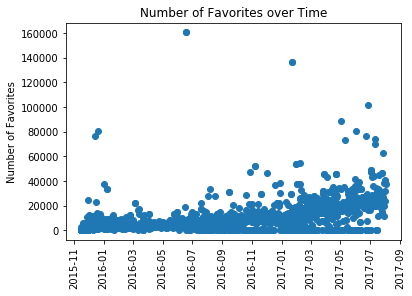

In [122]:
dates = matplotlib.dates.date2num(twitter_archive_master.timestamp)
plt.plot_date(dates, (twitter_archive_master.favorite_count))
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 90)
plt.title('Number of Favorites over Time')
plt.ylabel('Number of Favorites');

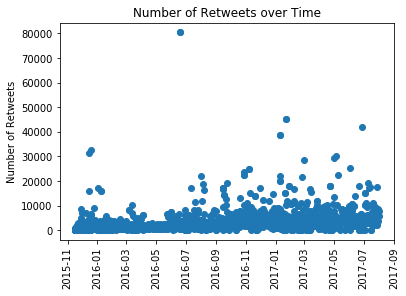

In [123]:
dates = matplotlib.dates.date2num(twitter_archive_master.timestamp)
plt.plot_date(dates, (twitter_archive_master.retweet_count))
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 90)
plt.title('Number of Retweets over Time')
plt.ylabel('Number of Retweets');

From the graph of favorites over datetime, a visible increase in the amount of favorites is noticeable as an overall trend. Although the same does not to be as strongly the case with retweets, as the dispersion is much greater, one can also say that retweets are much more committal than favorites and thus will show fewer numbers and more variance (this is just speculation). One might argue that this is caused by an overall rise in the accounts popularity, causing any posts at near the latter half of the sample to recieve a greater number of favorites and retweets.

Regardless of the reason, the lack of a uniform distribution, at least from a visual analysis, suggests that the timing of a date does not have a non-zero effect on the amount of favorites. This can have large consequences when looking in hindsight at the previous analysis. For instance, although labrador retrievers and golden retrievers were breeds with an outstanding number of retweets and favorites, even after weighting, it is possible that a greater portion of them were taken near the latter half of the sampling period, leading to an inflated number of favorites and retweets. Thus, a more accurate future analysis could probably take the timing of these posts into account, perhaps in a similar manner of weighting the tweets, or by binning them to similar time periods.

#### Citations
Defining Kindchenschema:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3260535/

American Kennel Club Dog Rankng stats:
https://www.akc.org/expert-advice/news/most-popular-dog-breeds-of-2018/

#### Making Final CSV

In [124]:
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index = False)